<a href="https://www.kaggle.com/code/shedai/llm-attention-dersi?scriptVersionId=252219125" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 0. Basis (Q, K, V Matrisleri)

Nedir? Nasıl Hesaplanır? Nasıl Kullanılır?

In [2]:
import numpy as np

# --- Fonksiyonlar ---
def softmax(x):
    """Numerik olarak stabil bir softmax hesaplaması."""
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def print_attention(tokens, attention_matrix):
    """Dikkat matrisini okunaklı bir şekilde yazdırır."""
    header = "         " + "  ".join([f"{token:<8}" for token in tokens])
    print(header)
    print("-" * len(header))
    for i, token in enumerate(tokens):
        row_str = f"{token:<9}"
        for val in attention_matrix[i]:
            row_str += f"{val:.4f}  "
        print(row_str)
    print("\n")

# --- Adım 0: Başlangıç Ayarları ---
print("--- BAŞLANGIÇ: RASTGELE MATRİSLER ---")
# Model ve vektör boyutları
d_model = 4
d_k = 3
np.random.seed(42) # Tekrarlanabilirlik için

# BAŞLANGIÇTAKİ RASTGELE AĞIRLIK MATRİSLERİ
# Bu matrisler tüm eğitim süreci boyunca güncellenecek.
W_q = np.random.rand(d_model, d_k)
W_k = np.random.rand(d_model, d_k)
W_v = np.random.rand(d_model, d_k) # Bu simülasyonda W_v'yi sabit tutacağız

print("Başlangıç W_q Matrisi:\n", np.round(W_q, 2))
print("\nBaşlangıç W_k Matrisi:\n", np.round(W_k, 2), "\n")
print("="*50)

# --- Adım 1: Eğitim Simülasyonu ---
# Basit bir eğitim veri seti ve hedefler
egitim_verisi = [
    {"metin": "akıllı köpek topu getirdi", "kaynak_idx": 1, "hedef_idx": 3}, # köpek -> getirdi
    {"metin": "yorgun kedi minderde uyudu", "kaynak_idx": 1, "hedef_idx": 3}, # kedi -> uyudu
]

iterasyon_sayisi = 3
ogrenme_orani = 0.1 # Matrisleri ne kadar değiştireceğimizi belirler

for i in range(iterasyon_sayisi):
    print(f"\n########### ITERASYON {i+1} ###########\n")
    
    for veri in egitim_verisi:
        metin = veri["metin"]
        kaynak_idx = veri["kaynak_idx"]
        hedef_idx = veri["hedef_idx"]
        tokenler = metin.split()
        
        print(f"--- Girdi Metni: '{metin}' ---")
        print(f"Hedef: '{tokenler[kaynak_idx]}' kelimesi '{tokenler[hedef_idx]}' kelimesine dikkat etsin.\n")
        
        # 1. Her girdi için rastgele kelime vektörleri (embedding) oluştur
        X = np.random.rand(len(tokenler), d_model)
        
        # 2. İleri Yayılım (Forward Pass) - Mevcut matrislerle dikkat skorlarını hesapla
        Q = np.dot(X, W_q)
        K = np.dot(X, W_k)
        
        skorlar = np.dot(Q, K.T) / np.sqrt(d_k)
        dikkat_agirliklari = softmax(skorlar)
        
        print(f"--- GÜNCELLEME ÖNCESİ DİKKAT MATRİSİ (İterasyon {i+1}) ---")
        print_attention(tokenler, dikkat_agirliklari)
        
        # 3. Hata Hesaplama (Simülasyon)
        # Hedef dikkat skorunun 1.0 olmasını istiyoruz. Mevcut skor ne kadar düşükse, hata o kadar büyük.
        mevcut_skor = dikkat_agirliklari[kaynak_idx, hedef_idx]
        hata = 1.0 - mevcut_skor
        print(f"'{tokenler[kaynak_idx]}' -> '{tokenler[hedef_idx]}' için mevcut dikkat skoru: {mevcut_skor:.4f}")
        print(f"Hesaplanan Hata (1.0 - skor): {hata:.4f}\n")
        
        # 4. Ağırlıkları Güncelleme (Simülasyon)
        # Bu, gerçek backpropagation'ın ÇOK basitleştirilmiş bir taklididir.
        # Fikir: Hedef skoru artırmak için W_q ve W_k'yi küçük bir miktar "dürtelim".
        # Düzeltme miktarını hata ve öğrenme oranı ile ölçekliyoruz.
        duzeltme_miktari = hata * ogrenme_orani
        
        # Sorumlu olan kelimelerin giriş vektörlerini (X) kullanarak güncelleme yapıyoruz.
        # Bu, güncellemenin doğru yönde olmasına yardımcı olur.
        W_q_guncellemesi = np.outer(X[kaynak_idx], Q[kaynak_idx]) * duzeltme_miktari
        W_k_guncellemesi = np.outer(X[hedef_idx], K[hedef_idx]) * duzeltme_miktari
        
        W_q += W_q_guncellemesi
        W_k += W_k_guncellemesi
        
        print(">>> Ağırlık Matrisleri Güncellendi! <<<\n")
        
        # 5. Doğrulama: Güncellenmiş matrislerle skorlar nasıl değişti?
        print(f"--- GÜNCELLEME SONRASI DOĞRULAMA (İterasyon {i+1}) ---")
        Q_yeni = np.dot(X, W_q)
        K_yeni = np.dot(X, W_k)
        skorlar_yeni = np.dot(Q_yeni, K_yeni.T) / np.sqrt(d_k)
        dikkat_yeni = softmax(skorlar_yeni)
        
        yeni_skor = dikkat_yeni[kaynak_idx, hedef_idx]
        print(f"'{tokenler[kaynak_idx]}' -> '{tokenler[hedef_idx]}' için YENİ dikkat skoru: {yeni_skor:.4f}")
        print(f"Skor Artışı: {(yeni_skor - mevcut_skor):.4f}\n")
        print_attention(tokenler, dikkat_yeni)
        print("-" * 50)

print("\n\n--- EĞİTİM SONRASI FİNAL MATRİSLER ---")
print("Rastgele başlayan matrisler, hedefler doğrultusunda güncellenerek evrimleşti.")
print("Final W_q Matrisi:\n", np.round(W_q, 2))
print("\nFinal W_k Matrisi:\n", np.round(W_k, 2))

--- BAŞLANGIÇ: RASTGELE MATRİSLER ---
Başlangıç W_q Matrisi:
 [[0.37 0.95 0.73]
 [0.6  0.16 0.16]
 [0.06 0.87 0.6 ]
 [0.71 0.02 0.97]]

Başlangıç W_k Matrisi:
 [[0.83 0.21 0.18]
 [0.18 0.3  0.52]
 [0.43 0.29 0.61]
 [0.14 0.29 0.37]] 


########### ITERASYON 1 ###########

--- Girdi Metni: 'akıllı köpek topu getirdi' ---
Hedef: 'köpek' kelimesi 'getirdi' kelimesine dikkat etsin.

--- GÜNCELLEME ÖNCESİ DİKKAT MATRİSİ (İterasyon 1) ---
         akıllı    köpek     topu      getirdi 
-----------------------------------------------
akıllı   0.2169  0.1953  0.2327  0.3552  
köpek    0.2230  0.1836  0.2271  0.3663  
topu     0.2198  0.1859  0.2278  0.3664  
getirdi  0.1925  0.1602  0.2146  0.4327  


'köpek' -> 'getirdi' için mevcut dikkat skoru: 0.3663
Hesaplanan Hata (1.0 - skor): 0.6337

>>> Ağırlık Matrisleri Güncellendi! <<<

--- GÜNCELLEME SONRASI DOĞRULAMA (İterasyon 1) ---
'köpek' -> 'getirdi' için YENİ dikkat skoru: 0.3933
Skor Artışı: 0.0269

         akıllı    köpek     topu      g

## 0.0.1 Basis : Yapay Sinir Ağı Kullanımı
    

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# --- Adım 0: Veri ve Kurulum ---
print("--- Adım 0: Veri ve Kurulum ---")
# Cümlemiz ve hedefimiz
sentence = "akıllı köpek topu getirdi"
tokens = sentence.split()
source_token = 'köpek'
target_token = 'getirdi'

print(f"Cümle: '{sentence}'")
print(f"Hedef: '{source_token}' kelimesi -> '{target_token}' kelimesine dikkat etsin.\n")

# Kelime dağarcığı oluşturma
vocab = sorted(list(set(tokens)))
word_to_ix = {word: i for i, word in enumerate(vocab)}
vocab_size = len(vocab)

# Girdi ve hedefi PyTorch tensörlerine çevirme
input_indices = torch.LongTensor([word_to_ix[w] for w in tokens])
source_idx = tokens.index(source_token)
target_idx = tokens.index(target_token)

# Hedef dikkat matrisi: (kaynak, hedef) pozisyonunda 1.0, diğer yerlerde 0.0
target_attention = torch.zeros(len(tokens), len(tokens))
target_attention[source_idx, target_idx] = 1.0

print("Veri PyTorch tensörlerine çevrildi.")
print(f"Girdi İndeksleri: {input_indices}")
print(f"Hedef Dikkat Matrisi (istenilen durum):\n{target_attention}\n")
print("="*60)


# --- Adım 1: Basit Sinir Ağı Modelini Tanımlama ---
print("\n--- Adım 1: PyTorch ile Basit Dikkat Ağı Modeli ---")

class SimpleAttentionNetwork(nn.Module):
    def __init__(self, vocab_size, d_model, d_k):
        super(SimpleAttentionNetwork, self).__init__()
        self.d_k = d_k
        
        # Kelime embedding'leri için katman (Bu W1 matrisine karşılık gelir)
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # Q, K, V dönüşümleri için Doğrusal katmanlar (Bunlar W_q, W_k, W_v matrisleridir)
        self.q_transform = nn.Linear(d_model, d_k, bias=False)
        self.k_transform = nn.Linear(d_model, d_k, bias=False)
        # Not: Bu basit örnekte V'yi kullanmayacağız ama tam bir modelde olurdu.

    def forward(self, input_indices):
        # 1. Girdi indekslerinden embedding vektörlerini al
        embedded_vectors = self.embedding(input_indices)  # Shape: (seq_len, d_model)
        
        # 2. Embedding'leri Q ve K uzaylarına yansıt
        Q = self.q_transform(embedded_vectors)  # Shape: (seq_len, d_k)
        K = self.k_transform(embedded_vectors)  # Shape: (seq_len, d_k)
        
        # 3. Dikkat skorlarını hesapla
        # (seq_len, d_k) @ (d_k, seq_len) -> (seq_len, seq_len)
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        
        return attention_scores, Q, K

# Model hiperparametreleri
D_MODEL = 16
D_K = 8
LEARNING_RATE = 0.1
EPOCHS = 100

# Modeli, kayıp fonksiyonunu ve optimize ediciyi oluştur
model = SimpleAttentionNetwork(vocab_size, D_MODEL, D_K)
criterion = nn.MSELoss() # Ortalama Karesel Hata: Modelin çıktısı ile hedef arasındaki farkı ölçer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Sinir ağı modeli, kayıp fonksiyonu ve optimize edici hazır.\n")
print("="*60)

# --- Adım 2: Eğitim Döngüsü ---
print("\n--- Adım 2: Sinir Ağı Eğitim Döngüsü ---")

def print_attention_torch(tokens, attention_tensor):
    """PyTorch tensörünü alıp dikkat matrisini yazdırır."""
    attention_np = attention_tensor.detach().numpy() # Gradyan takibini bırakıp numpy'a çevir
    # Softmax uygulayarak olasılıklara çevir
    e_x = np.exp(attention_np - np.max(attention_np, axis=-1, keepdims=True))
    probs = e_x / np.sum(e_x, axis=-1, keepdims=True)
    
    header = "         " + "  ".join([f"{token:<8}" for token in tokens])
    print(header)
    print("-" * len(header))
    for i, token in enumerate(tokens):
        row_str = f"{token:<9}"
        for val in probs[i]:
            row_str += f"{val:.4f}  "
        print(row_str)
    print("\n")


# Eğitimin başlangıcındaki duruma bakalım
print("--- EĞİTİM ÖNCESİ DURUM ---")
initial_scores, _, _ = model(input_indices)
print("Başlangıçtaki Dikkat Matrisi (Rastgele):")
print_attention_torch(tokens, initial_scores)
print(f"Başlangıçtaki W_q matrisi:\n{np.round(model.q_transform.weight.data.numpy(), 2)}\n")


for epoch in range(EPOCHS):
    # İleri Yayılım: Modelin mevcut ağırlıklarla tahmin yapması
    output_scores, _, _ = model(input_indices)
    
    # Kayıp Hesabı: Modelin tahmini ile bizim hedefimiz arasındaki fark
    loss = criterion(output_scores, target_attention)
    
    # Geriye Yayılım ve Optimizasyon
    optimizer.zero_grad()  # Önceki adımların gradyanlarını temizle
    loss.backward()        # Kaybı azaltmak için gradyanları hesapla (AutoGrad)
    optimizer.step()       # Optimize edici ile ağırlıkları (W_q, W_k, embedding) güncelle
    
    if (epoch + 1) % 25 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Kayıp (Loss): {loss.item():.4f}")

print("\n--- EĞİTİM SONRASI DURUM ---")
final_scores, final_Q, final_K = model(input_indices)
print("\nEğitim Sonrası Nihai Dikkat Matrisi:")
print_attention_torch(tokens, final_scores)

print("Q ve K matrisleri artık hedefe yönelik dönüşümler yapmayı 'öğrendi'.")
print(f"\nEğitim Sonrası Final W_q matrisi:\n{np.round(model.q_transform.weight.data.numpy(), 2)}")
print(f"\nEğitim Sonrası Final W_k matrisi:\n{np.round(model.k_transform.weight.data.numpy(), 2)}")

--- Adım 0: Veri ve Kurulum ---
Cümle: 'akıllı köpek topu getirdi'
Hedef: 'köpek' kelimesi -> 'getirdi' kelimesine dikkat etsin.

Veri PyTorch tensörlerine çevrildi.
Girdi İndeksleri: tensor([0, 2, 3, 1])
Hedef Dikkat Matrisi (istenilen durum):
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])


--- Adım 1: PyTorch ile Basit Dikkat Ağı Modeli ---
Sinir ağı modeli, kayıp fonksiyonu ve optimize edici hazır.


--- Adım 2: Sinir Ağı Eğitim Döngüsü ---
--- EĞİTİM ÖNCESİ DURUM ---
Başlangıçtaki Dikkat Matrisi (Rastgele):
         akıllı    köpek     topu      getirdi 
-----------------------------------------------
akıllı   0.2620  0.2668  0.1938  0.2774  
köpek    0.2796  0.2789  0.2194  0.2221  
topu     0.2688  0.1861  0.2060  0.3390  
getirdi  0.2682  0.2539  0.2289  0.2490  


Başlangıçtaki W_q matrisi:
[[ 0.21  0.14  0.04 -0.24  0.11 -0.05  0.08 -0.02  0.18 -0.16 -0.16  0.07
   0.18 -0.14  0.2  -0.1 ]
 [-0.18  0.04  0.22 -0.12 -0.0

## 0.1. Basis K ve V ilişkisi

In [4]:
import numpy as np

# --- Fonksiyonlar ---
def softmax(x):
    """Numerik olarak stabil bir softmax hesaplaması."""
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def print_attention(tokens, attention_matrix):
    """Dikkat matrisini okunaklı bir şekilde yazdırır."""
    header = "         " + "  ".join([f"{token:<8}" for token in tokens])
    print(header)
    print("-" * len(header))
    for i, token in enumerate(tokenler):
        row_str = f"{token:<9}"
        for val in attention_matrix[i]:
            row_str += f"{val:.4f}  "
        print(row_str)
    print("\n")

# --- Adım 0: Başlangıç Ayarları ---
print("--- BAŞLANGIÇ: RASTGELE MATRİSLER ---")
d_model = 4
d_k = 3 # K, Q ve V'nin boyutunu aynı tutuyoruz (d_k = d_v)
np.random.seed(42)

W_q = np.random.rand(d_model, d_k)
W_k = np.random.rand(d_model, d_k)
W_v = np.random.rand(d_model, d_k)

print("Başlangıç W_q Matrisi:\n", np.round(W_q, 2))
print("\nBaşlangıç W_k Matrisi:\n", np.round(W_k, 2))
print("\nBaşlangıç W_v Matrisi:\n", np.round(W_v, 2), "\n")
print("="*60)

# --- Adım 1: Eğitim Simülasyonu ---
egitim_verisi = [
    {"metin": "akıllı köpek topu getirdi", "kaynak_idx": 1, "hedef_idx": 3}, # köpek -> getirdi
]

iterasyon_sayisi = 1 # Anlatımı sade tutmak için 1 iterasyon yeterli
ogrenme_orani = 0.1

for i in range(iterasyon_sayisi):
    print(f"\n########### ITERASYON {i+1} ###########\n")
    
    for veri in egitim_verisi:
        metin = veri["metin"]
        kaynak_idx = veri["kaynak_idx"]
        hedef_idx = veri["hedef_idx"]
        tokenler = metin.split()
        
        print(f"--- Girdi Metni: '{metin}' ---")
        print(f"Hedef: '{tokenler[kaynak_idx]}' kelimesi '{tokenler[hedef_idx]}' kelimesine dikkat etsin.\n")
        
        X = np.round(np.random.rand(len(tokenler), d_model), 2)
        print(f"Başlangıç Embedding Matrisi X (boyut: {X.shape}):\n{X}\n")

        # İleri Yayılım (Forward Pass)
        Q = np.dot(X, W_q)
        K = np.dot(X, W_k)
        V = np.dot(X, W_v)
        
        print(f"Oluşturulan Değer (V) Matrisi (Her kelimenin 'asıl içeriği'):\n{np.round(V,2)}\n")

        # Q ve K ile dikkat ağırlıklarını hesapla
        skorlar = np.dot(Q, K.T) / np.sqrt(d_k)
        dikkat_agirliklari = softmax(skorlar)
        
        print(f"--- Adım A: Dikkat Ağırlıklarının Hesaplanması (Q ve K kullanıldı) ---")
        print("Bu matris, 'nereye bakılacağını' ve 'ne kadar yoğunlukta bakılacağını' söyler.")
        print_attention(tokenler, dikkat_agirliklari)
        
        # --- YENİ EKLENEN ADIM: V MATRİSİNİN KULLANIMI ---
        print(f"--- Adım B: Final Çıktının Üretilmesi (V matrisi kullanıldı) ---")
        print("Şimdi, dikkat ağırlıkları (A) ile Değer matrisi (V) çarpılır: Çıktı = A @ V")
        print("Bu işlem, her kelime için diğer kelimelerin 'Değer'lerinin ağırlıklı bir ortalamasını alarak yeni bir vektör oluşturur.\n")
        
        final_cikti = np.dot(dikkat_agirliklari, V)

        print(f"ATTENTION KATMANININ GERÇEK FİNAL ÇIKTISI (boyut: {final_cikti.shape}):\n{np.round(final_cikti, 2)}\n")

        print("--- Çıktının Yorumu ---")
        kopek_orijinal_vektor = X[kaynak_idx]
        kopek_yeni_vektor = final_cikti[kaynak_idx]
        getirdi_deger_vektoru = V[hedef_idx]
        
        print(f"'{tokenler[kaynak_idx]}' kelimesinin orijinal vektörü: {kopek_orijinal_vektor}")
        print(f"'{tokenler[kaynak_idx]}' kelimesinin YENİ, bağlamsallaşmış vektörü: {np.round(kopek_yeni_vektor, 2)}")
        print("\nBu yeni vektör, artık sadece 'köpek' kelimesinin anlamını değil, aynı zamanda yüksek dikkat ettiği")
        print(f"'{tokenler[hedef_idx]}' kelimesinin Değer (V) vektörünün ({np.round(getirdi_deger_vektoru,2)}) anlamsal bilgisini de içinde barındırır.")
        print("İşte V matrisinin görevi, bu zenginleştirilmiş yeni temsilleri yaratmaktır!\n")
        print("-" * 50)

        # Hata ve Güncelleme Adımları (önceki gibi devam ediyor)
        mevcut_skor = dikkat_agirliklari[kaynak_idx, hedef_idx]
        hata = 1.0 - mevcut_skor
        duzeltme_miktari = hata * ogrenme_orani
        
        W_q += np.outer(X[kaynak_idx], Q[kaynak_idx]) * duzeltme_miktari
        W_k += np.outer(X[hedef_idx], K[hedef_idx]) * duzeltme_miktari
        
        toplam_dikkat = np.sum(dikkat_agirliklari, axis=0)
        en_onemli_kelime_idx = np.argmax(toplam_dikkat)
        W_v += np.outer(X[en_onemli_kelime_idx], V[en_onemli_kelime_idx]) * duzeltme_miktari
        print("Ağırlık matrisleri (W_q, W_k, W_v) güncellendi...\n")

print("\n\n--- EĞİTİM SONRASI FİNAL MATRİSLER ---")
print("Rastgele başlayan matrisler, hem 'etiketleri' (K) hem de 'içerikleri' (V) optimize edecek şekilde evrimleşti.")
print("Final W_q Matrisi:\n", np.round(W_q, 2))
print("\nFinal W_k Matrisi:\n", np.round(W_k, 2))
print("\nFinal W_v Matrisi:\n", np.round(W_v, 2))

--- BAŞLANGIÇ: RASTGELE MATRİSLER ---
Başlangıç W_q Matrisi:
 [[0.37 0.95 0.73]
 [0.6  0.16 0.16]
 [0.06 0.87 0.6 ]
 [0.71 0.02 0.97]]

Başlangıç W_k Matrisi:
 [[0.83 0.21 0.18]
 [0.18 0.3  0.52]
 [0.43 0.29 0.61]
 [0.14 0.29 0.37]]

Başlangıç W_v Matrisi:
 [[0.46 0.79 0.2 ]
 [0.51 0.59 0.05]
 [0.61 0.17 0.07]
 [0.95 0.97 0.81]] 


########### ITERASYON 1 ###########

--- Girdi Metni: 'akıllı köpek topu getirdi' ---
Hedef: 'köpek' kelimesi 'getirdi' kelimesine dikkat etsin.

Başlangıç Embedding Matrisi X (boyut: (4, 4)):
[[0.3  0.1  0.68 0.44]
 [0.12 0.5  0.03 0.91]
 [0.26 0.66 0.31 0.52]
 [0.55 0.18 0.97 0.78]]

Oluşturulan Değer (V) Matrisi (Her kelimenin 'asıl içeriği'):
[[1.02 0.84 0.46]
 [1.19 1.27 0.78]
 [1.14 1.15 0.52]
 [1.67 1.46 0.81]]

--- Adım A: Dikkat Ağırlıklarının Hesaplanması (Q ve K kullanıldı) ---
Bu matris, 'nereye bakılacağını' ve 'ne kadar yoğunlukta bakılacağını' söyler.
         akıllı    köpek     topu      getirdi 
---------------------------------------------

## 0.2. Basis ( Sorgu Örneği ) 

In [5]:
import numpy as np

# --- Fonksiyonlar ---
def softmax(x):
    e_x = np.exp(x - np.max(x)) # Numerik stabilite için
    return e_x / np.sum(e_x)

# --- Adım 1: "Eğitilmiş" Model ve Bilgi Bankası ---
print("--- Adım 1: 'Eğitilmiş' Modelin ve Bilgi Bankasının Hazırlanması ---")

# Önceki kodumuzdan elde ettiğimiz, artık rastgele olmayan, "eğitilmiş" ağırlık matrislerini kullanıyoruz.
W_q = np.array([[0.41, 0.44, 0.62], [0.5, 0.48, 0.51], [0.2, 0.21, 0.22], [0.21, 0.21, 0.23]])
W_k = np.array([[0.51, 0.46, 0.36], [0.65, 0.65, 0.52], [0.38, 0.32, 0.27], [0.4, 0.35, 0.3]])
W_v = np.array([[0.4, 0.65, 0.43], [0.49, 0.68, 0.49], [0.21, 0.24, 0.21], [0.22, 0.25, 0.23]])

print("Önceki eğitimden gelen 'bilge' W_q, W_k, W_v matrisleri yüklendi.\n")

# Modelin "bildiği" her şeyi içeren bilgi bankası (Context)
bilgi_bankasi_metni = "akıllı köpek topu getirdi yorgun kedi minderde uyudu"
context_tokenler = bilgi_bankasi_metni.split()

print(f"Bilgi Bankası (Context): '{bilgi_bankasi_metni}'")
print(f"Context Token'ları: {context_tokenler}\n")

# Bilgi bankasındaki her kelime için embedding oluşturalım (simülasyon)
d_model = 4
np.random.seed(10) # Farklı bir seed
X_context = np.random.rand(len(context_tokenler), d_model)

# BİLGİ BANKASININ K ve V MATRİSLERİNİ HESAPLA (Modelin Hafızası)
K_context = np.dot(X_context, W_k)
V_context = np.dot(X_context, W_v)

print("Bilgi bankası için K (Anahtar) ve V (Değer) matrisleri hesaplandı.")
print(f"K_context boyutu (hafızadaki etiketler): {K_context.shape}")
print(f"V_context boyutu (hafızadaki içerikler): {V_context.shape}\n")
print("="*60)


# --- Adım 2: Soruyu İşleme ---
print("\n--- Adım 2: Yeni Bir Soru Geldi! ---")
soru_metni = "kedi köpek ne yaptı"
soru_tokenler = soru_metni.split()
# Cevaplamak istediğimiz anahtar kelimeler
sorgu_kelimeleri = ["kedi", "köpek"] 

print(f"Soru: '{soru_metni}'")
print(f"Cevaplanacak anahtar kelimeler: {sorgu_kelimeleri}\n")

# Soru kelimeleri için embedding oluşturalım
X_soru = np.random.rand(len(soru_tokenler), d_model)

# SORU İÇİN Q MATRİSİNİ HESAPLA
Q_soru = np.dot(X_soru, W_q)
print("Soru için Q (Sorgu) matrisi hesaplandı.")
print(f"Q_soru boyutu: {Q_soru.shape}\n")
print("="*60)


# --- Adım 3: Cevap için Dikkat Mekanizmasını Çalıştırma ---
print("\n--- Adım 3: Dikkat Mekanizması ile Cevap Bulma ---")

for kelime in sorgu_kelimeleri:
    print(f"\n>>> SORGU: '{kelime}' kelimesi ne yaptı? <<<\n")
    
    # İlgili kelimenin Q vektörünü al
    kelime_index_in_soru = soru_tokenler.index(kelime)
    Q_tek_kelime = Q_soru[kelime_index_in_soru]
    
    print(f"1. '{kelime}' için SORGU (Q) vektörü alındı: {np.round(Q_tek_kelime, 2)}")
    
    # 2. Çapraz Dikkat Skorları Hesaplanıyor
    dikkat_skorlari = np.dot(Q_tek_kelime, K_context.T)
    
    print("\n2. Bu sorgu, bilgi bankasındaki her kelimeyle karşılaştırıldı (Sadece Q ve K kullanıldı).")
    
    # 3. Softmax ile Olasılık Dağılımı
    dikkat_agirliklari = softmax(dikkat_skorlari)
    print("\n3. Softmax ile 'dikkat ağırlıkları' bulundu (Nereye ne kadar dikkat etmeli?).")
    agirlik_raporu = "   "
    for i, token in enumerate(context_tokenler):
        agirlik_raporu += f"'{token}':{dikkat_agirliklari[i]:.3f}  "
    print(agirlik_raporu)

    # --- YENİ ve GÜNCEL ADIM 4: V MATRİSİ İLE CEVAP ÜRETME ---
    print("\n4. V Matrisi ile Cevap Üretimi (Attention'ın asıl çıktısı)")
    
    # Adım 4a: Bağlamsal Çıktı Vektörünü Sentezleme (A @ V)
    print("   4a. Dikkat ağırlıkları, V_context matrisiyle çarpılarak tek bir 'cevap' vektörü sentezlendi.")
    Cikti_vektoru = np.dot(dikkat_agirliklari, V_context)
    print(f"       -> Sentezlenen Çıktı Vektörü: {np.round(Cikti_vektoru, 2)}")

    # Adım 4b: En Benzer Kelimeyi Bulma
    print("\n   4b. Bu sentezlenmiş vektöre en çok benzeyen kelime hangisi?")
    # Bu yeni vektörün, bilgi bankasındaki hangi kelimenin 'Değer'ine (V) en çok benzediğini bulalım.
    # Benzerlik için dot product kullanabiliriz.
    benzerlik_skorlari = np.dot(V_context, Cikti_vektoru.T)
    cevap_index = np.argmax(benzerlik_skorlari)
    cevap_kelimesi = context_tokenler[cevap_index]
    print(f"       -> En Yüksek Benzerlik Skoruyla Bulunan Cevap: '{cevap_kelimesi}'")
    
    # --- YENİ ve GÜNCEL ADIM 5: SONUÇ ---
    print("\n5. Sonuç")
    print("-" * 20)
    print(f"SONUÇ: '{kelime}' ne yaptı? -> CEVAP: '{cevap_kelimesi}'")
    print("-" * 20)

print("\n\n--- ÖZET (GÜNCELLENDİ) ---")
print("Model, sorudaki kelimeleri birer SORG_U (Q) olarak kullandı.")
print("Bu sorguları, hafızasındaki ANAHTARLAR (K) ile karşılaştırarak dikkat ağırlıklarını belirledi.")
print("Bu ağırlıkları, hafızadaki asıl anlamsal içeriği taşıyan DEĞERLER (V) ile çarparak bağlamsal bir 'cevap vektörü' sentezledi.")
print("Son olarak, bu sentezlenmiş vektörü en iyi temsil eden kelimeyi bularak nihai cevabını verdi.")

--- Adım 1: 'Eğitilmiş' Modelin ve Bilgi Bankasının Hazırlanması ---
Önceki eğitimden gelen 'bilge' W_q, W_k, W_v matrisleri yüklendi.

Bilgi Bankası (Context): 'akıllı köpek topu getirdi yorgun kedi minderde uyudu'
Context Token'ları: ['akıllı', 'köpek', 'topu', 'getirdi', 'yorgun', 'kedi', 'minderde', 'uyudu']

Bilgi bankası için K (Anahtar) ve V (Değer) matrisleri hesaplandı.
K_context boyutu (hafızadaki etiketler): (8, 3)
V_context boyutu (hafızadaki içerikler): (8, 3)


--- Adım 2: Yeni Bir Soru Geldi! ---
Soru: 'kedi köpek ne yaptı'
Cevaplanacak anahtar kelimeler: ['kedi', 'köpek']

Soru için Q (Sorgu) matrisi hesaplandı.
Q_soru boyutu: (4, 3)


--- Adım 3: Dikkat Mekanizması ile Cevap Bulma ---

>>> SORGU: 'kedi' kelimesi ne yaptı? <<<

1. 'kedi' için SORGU (Q) vektörü alındı: [0.61 0.64 0.82]

2. Bu sorgu, bilgi bankasındaki her kelimeyle karşılaştırıldı (Sadece Q ve K kullanıldı).

3. Softmax ile 'dikkat ağırlıkları' bulundu (Nereye ne kadar dikkat etmeli?).
   'akıllı':0.117 

# 1. Dense / Full Attention 

'makine öğrenmesi harika bir alan' cümlesi için Attention Mekanizması Analizi
1. Adım: Kelime Gömme (Word Embeddings) - Boyut: 12
  'makine': [0.37 0.95 0.73 0.6  0.16 0.16 0.06 0.87 0.6  0.71 0.02 0.97]
  'öğrenmesi': [0.83 0.21 0.18 0.18 0.3  0.52 0.43 0.29 0.61 0.14 0.29 0.37]
  'harika': [0.46 0.79 0.2  0.51 0.59 0.05 0.61 0.17 0.07 0.95 0.97 0.81]
  'bir': [0.3  0.1  0.68 0.44 0.12 0.5  0.03 0.91 0.26 0.66 0.31 0.52]
  'alan': [0.55 0.18 0.97 0.78 0.94 0.89 0.6  0.92 0.09 0.2  0.05 0.33]
------------------------------------------------------------
2. Adım: Q, K, V Vektörlerinin Hesaplanması - Boyut: 4
Örnek olarak ilk kelimenin ('makine') Q, K, V vektörleri:
  Q_1: [3.22 3.26 2.57 3.28]
  K_1: [3.46 2.9  3.82 3.16]
  V_1: [2.72 3.22 2.81 3.18]
------------------------------------------------------------
3. Adım: Ham Dikkat Skorları (Q @ K.T)
Her satır bir 'sorgu' kelimesini, her sütun bir 'anahtar' kelimesini temsil eder.
[[40.77 22.64 35.45 28.23 38.83]
 [28.93 16.33 25.67 20.11 

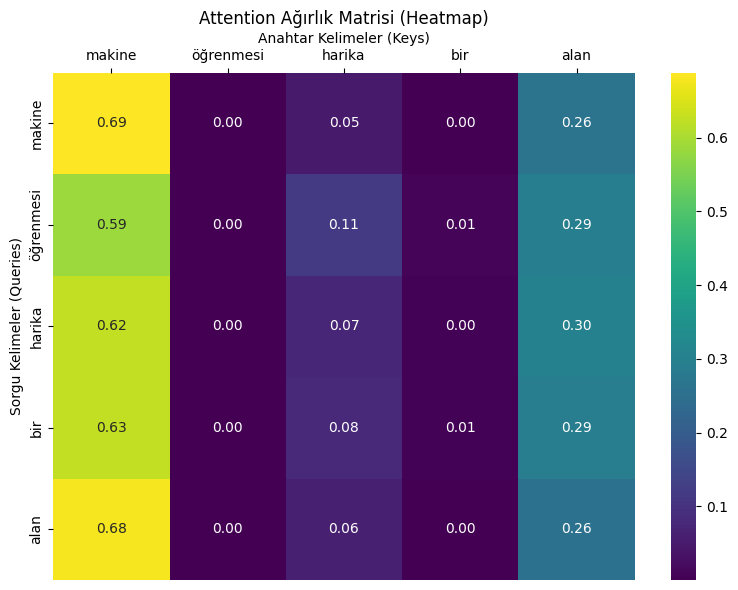

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def softmax(x):
    """Numerik olarak stabil bir softmax fonksiyonu."""
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def visualize_attention(sentence, attention_matrix):
    """Attention matrisini bir ısı haritası olarak görselleştirir."""
    
    # Türkçe karakterleri destekleyen bir font bulma denemesi
    try:
        # Örnek olarak yaygın bir font veya sisteminizde olan bir fontu deneyin
        # Linux için: "DejaVu Sans", Windows için: "Arial", macOS için: "Helvetica Neue"
        font_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', size=12)
        plt.rcParams['font.family'] = font_prop.get_name()
    except:
        print("\nUyarı: Türkçe karakterler için 'DejaVu Sans' fontu bulunamadı. Etiketler düzgün görünmeyebilir.")
        print("Görselleştirmeyi iyileştirmek için sisteminizde var olan bir .ttf font dosyasının yolunu koda ekleyebilirsiniz.\n")


    tokens = sentence.split()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, annot=True, fmt=".2f", cmap="viridis", ax=ax)
    
    ax.set_title("Attention Ağırlık Matrisi (Heatmap)")
    ax.set_xlabel("Anahtar Kelimeler (Keys)")
    ax.set_ylabel("Sorgu Kelimeler (Queries)")
    ax.xaxis.tick_top()  # X ekseni etiketlerini üste taşı
    ax.xaxis.set_label_position('top')
    
    plt.tight_layout()
    plt.show()

def attention_step_by_step(sentence):
    """
    Verilen bir cümle için attention mekanizmasını adım adım çalıştırır ve görselleştirir.
    """
    # makine öğrenmesi harika bir alan
    print(f"'{sentence}' cümlesi için Attention Mekanizması Analizi")
    print("=" * 60)

    tokens = sentence.split()
    vocab_size = len(tokens)
    
    # --- 1. Adım: Model Parametreleri ve Gömme Vektörleri ---
    # Eğitim kolaylığı için boyutları küçük tutuyoruz.
    d_model = 12  # Her kelimenin temsil edildiği vektör boyutu (Embedding boyutu)
    d_k = 4       # Query ve Key vektörlerinin boyutu (d_v de aynı olacak)
    
    # Her çalıştırmada aynı sonuçları almak için rastgelelik tohumu
    np.random.seed(42) 
    
    # Her kelime için rastgele bir gömme vektörü oluşturalım.
    # Gerçekte bu vektörler bir embedding katmanından gelir.
    embeddings = np.random.rand(vocab_size, d_model)
    
    print(f"1. Adım: Kelime Gömme (Word Embeddings) - Boyut: {d_model}")
    for i, token in enumerate(tokens):
        print(f"  '{token}': {np.round(embeddings[i], 2)}")
    print("-" * 60)
        
    # --- 2. Adım: Ağırlık Matrisleri ve Q, K, V Hesaplanması ---
    # Bu matrisler normalde modelin eğitim sırasında öğrendiği ağırlıklardır.
    # Biz burada rastgele ama sabit matrisler kullanacağız.
    W_q = np.random.rand(d_model, d_k)
    W_k = np.random.rand(d_model, d_k)
    W_v = np.random.rand(d_model, d_k) # d_v = d_k varsayalım
    
    # Her kelime için Q, K, V vektörlerini hesapla
    Q = embeddings @ W_q
    K = embeddings @ W_k
    V = embeddings @ W_v
    
    print(f"2. Adım: Q, K, V Vektörlerinin Hesaplanması - Boyut: {d_k}")
    print("Örnek olarak ilk kelimenin ('{}') Q, K, V vektörleri:".format(tokens[0]))
    print(f"  Q_1: {np.round(Q[0], 2)}")
    print(f"  K_1: {np.round(K[0], 2)}")
    print(f"  V_1: {np.round(V[0], 2)}")
    print("-" * 60)
    
    # --- 3. Adım: Ham Dikkat Skorları ---
    # Her sorgunun (Q) her anahtarla (K) ne kadar ilişkili olduğunu ölçeriz.
    # Formül: scores = Q * K^T
    scores = Q @ K.T
    
    print("3. Adım: Ham Dikkat Skorları (Q @ K.T)")
    print("Her satır bir 'sorgu' kelimesini, her sütun bir 'anahtar' kelimesini temsil eder.")
    print(np.round(scores, 2))
    print("-" * 60)
    
    # --- 4. Adım: Ölçekleme ---
    # Gradyanların çok küçülmesini engellemek için skorları ölçekleriz.
    # Formül: scores / sqrt(d_k)
    scaled_scores = scores / np.sqrt(d_k)
    
    print(f"4. Adım: Ölçeklenmiş Skorlar (Skorlar / sqrt({d_k}))")
    print(np.round(scaled_scores, 2))
    print("-" * 60)
    
    # --- 5. Adım: Softmax ---
    # Ölçeklenmiş skorları [0, 1] aralığında bir olasılık dağılımına dönüştürürüz.
    # Her satırın toplamı 1 olur. Bu bizim ATTENTION matrisimizdir.
    attention_weights = softmax(scaled_scores)
    
    print("5. Adım: Softmax ile Ağırlıkların Hesaplanması (Attention Matrisi)")
    print("Her kelimenin diğer kelimelere ne kadar 'dikkat' edeceğini gösterir.")
    print(np.round(attention_weights, 2))
    print("-" * 60)
    
    # --- 6. Adım: Sonuç Vektörlerinin Hesaplanması ---
    # Her kelime için nihai çıktı, dikkat ağırlıkları ile Değer (V) vektörlerinin
    # ağırlıklı toplamıdır.
    # Formül: output = attention_weights * V
    output = attention_weights @ V
    
    print("6. Adım: Nihai Çıktı Vektörleri (Attention_Weights @ V)")
    print("Her kelimenin yeni vektörü, cümlenin bağlam bilgisini içerir.")
    for i, token in enumerate(tokens):
        print(f"  '{token}' için yeni vektör: {np.round(output[i], 2)}")
    print("-" * 60)
    
    # --- 7. Adım: Görselleştirme ---
    print("7. Adım: Attention Matrisinin Görselleştirilmesi")
    visualize_attention(sentence, attention_weights)
    

if __name__ == '__main__':
    # Analiz edilecek örnek cümle
    ornek_cumle = "makine öğrenmesi harika bir alan"
    attention_step_by_step(ornek_cumle)

# 2. Sparse Attention (Dikkat)

'Yapay zeka modelleri uzun metinleri işlerken zorlanır' cümlesi için Full vs. Sparse Attention Analizi
Sparse Attention Pencere Boyutu: 1 (her kelime sağına ve soluna 1 kelimeye bakar)
1-4. Adımlar: Gömme, Q,K,V, Skor ve Ölçekleme işlemleri her iki yöntem için de ortaktır.
Ölçeklenmiş Skor Matrisi:
[[19.   12.66 18.05 14.02 19.24 16.08 15.45]
 [12.83  8.65 12.31  9.56 13.27 10.98 10.42]
 [16.39 11.06 15.57 12.08 16.62 13.87 13.39]
 [15.85 10.61 15.09 11.73 16.12 13.46 12.88]
 [18.89 12.63 17.97 13.92 19.22 15.98 15.39]
 [18.56 12.44 17.67 13.72 18.88 15.74 15.11]
 [15.62 10.41 14.86 11.54 15.86 13.24 12.69]]
--------------------------------------------------------------------------------
a) Full Attention Ağırlıkları (Softmax uygulanmış hali)
[[0.36 0.   0.14 0.   0.46 0.02 0.01]
 [0.29 0.   0.17 0.01 0.45 0.05 0.03]
 [0.35 0.   0.15 0.   0.44 0.03 0.02]
 [0.34 0.   0.16 0.01 0.45 0.03 0.02]
 [0.35 0.   0.14 0.   0.48 0.02 0.01]
 [0.35 0.   0.14 0.   0.48 0.02 0.01]
 [0.34 0.   0.16 0.

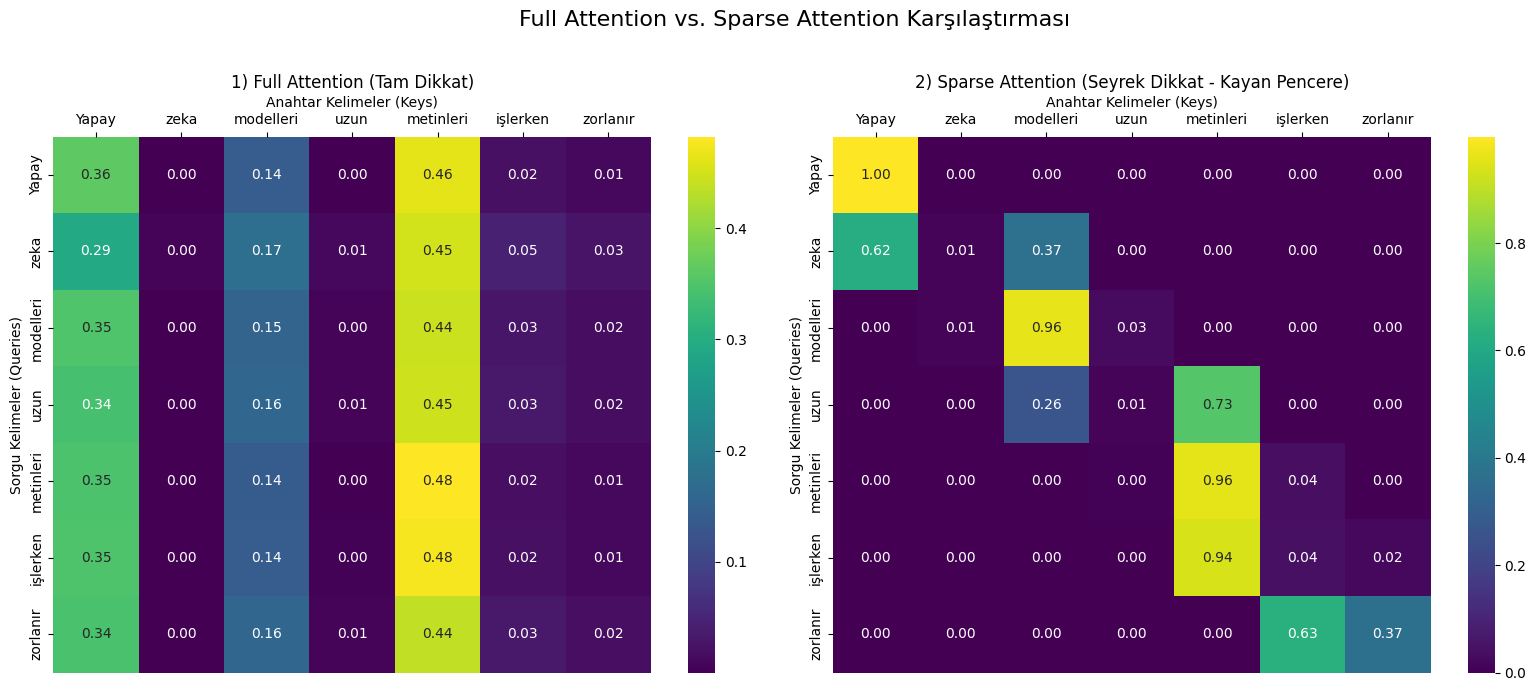

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --- Bir önceki koddan alınan yardımcı fonksiyonlar ---
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

# YENİ KARŞILAŞTIRMA GÖRSELLEŞTİRME FONKSİYONU
def visualize_attention_comparison(sentence, full_attention_matrix, sparse_attention_matrix):
    """Full ve Sparse Attention matrislerini yan yana görselleştirir."""
    
    # Türkçe karakter desteği için font ayarı
    try:
        font_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', size=10)
        plt.rcParams['font.family'] = font_prop.get_name()
    except:
        print("\nUyarı: 'DejaVu Sans' fontu bulunamadı. Görseldeki etiketler düzgün görünmeyebilir.\n")
    
    tokens = sentence.split()
    
    # İki grafiği yan yana çizmek için bir figure ve subplotlar oluştur
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Sol Grafik: Full Attention
    sns.heatmap(full_attention_matrix, xticklabels=tokens, yticklabels=tokens, annot=True, fmt=".2f", cmap="viridis", ax=axes[0])
    axes[0].set_title("1) Full Attention (Tam Dikkat)")
    axes[0].set_xlabel("Anahtar Kelimeler (Keys)")
    axes[0].set_ylabel("Sorgu Kelimeler (Queries)")
    axes[0].xaxis.tick_top()
    axes[0].xaxis.set_label_position('top')
    
    # Sağ Grafik: Sparse Attention
    sns.heatmap(sparse_attention_matrix, xticklabels=tokens, yticklabels=tokens, annot=True, fmt=".2f", cmap="viridis", ax=axes[1])
    axes[1].set_title("2) Sparse Attention (Seyrek Dikkat - Kayan Pencere)")
    axes[1].set_xlabel("Anahtar Kelimeler (Keys)")
    axes[1].set_ylabel("Sorgu Kelimeler (Queries)")
    axes[1].xaxis.tick_top()
    axes[1].xaxis.set_label_position('top')
    
    fig.suptitle("Full Attention vs. Sparse Attention Karşılaştırması", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# YENİ MASKE OLUŞTURMA FONKSİYONU
def create_sliding_window_mask(sequence_length, window_size):
    """
    Kayan pencere (sliding window) sparse attention için bir maske oluşturur.
    Pencere dışındaki pozisyonlara -infinity değeri atanır.
    """
    mask = np.zeros((sequence_length, sequence_length))
    for i in range(sequence_length):
        for j in range(sequence_length):
            # Eğer j pozisyonu, i'nin penceresi dışındaysa, maskele
            if abs(i - j) > window_size:
                mask[i, j] = -np.inf
    return mask

def attention_comparison_step_by_step(sentence, window_size=1):
    """
    Full ve Sparse Attention mekanizmalarını karşılaştırır.
    """
    print(f"'{sentence}' cümlesi için Full vs. Sparse Attention Analizi")
    print(f"Sparse Attention Pencere Boyutu: {window_size} (her kelime sağına ve soluna {window_size} kelimeye bakar)")
    print("=" * 80)

    tokens = sentence.split()
    vocab_size = len(tokens)
    
    # --- 1. ve 2. Adımlar (Ortak) ---
    d_model = 12
    d_k = 4
    np.random.seed(42) 
    
    embeddings = np.random.rand(vocab_size, d_model)
    W_q = np.random.rand(d_model, d_k)
    W_k = np.random.rand(d_model, d_k)
    W_v = np.random.rand(d_model, d_k)
    
    Q = embeddings @ W_q
    K = embeddings @ W_k
    V = embeddings @ W_v
    
    # --- 3. ve 4. Adımlar (Ortak) ---
    scores = Q @ K.T
    scaled_scores = scores / np.sqrt(d_k)
    
    print("1-4. Adımlar: Gömme, Q,K,V, Skor ve Ölçekleme işlemleri her iki yöntem için de ortaktır.")
    print("Ölçeklenmiş Skor Matrisi:")
    print(np.round(scaled_scores, 2))
    print("-" * 80)
    
    # --- FULL ATTENTION HESAPLAMASI ---
    full_attention_weights = softmax(scaled_scores)
    print("a) Full Attention Ağırlıkları (Softmax uygulanmış hali)")
    print(np.round(full_attention_weights, 2))
    print("-" * 80)

    # --- SPARSE ATTENTION HESAPLAMASI ---
    
    # 5. Adım: Seyreltme Maskesi Oluşturma (YENİ ADIM)
    print("b) Sparse Attention için adımlar:")
    print("5. Adım: Kayan Pencere Maskesi Oluşturma")
    print("Pencere dışındaki konumlara -inf değeri atanır, böylece softmax sonrası skorları 0 olur.")
    mask = create_sliding_window_mask(vocab_size, window_size)
    print(mask)
    print("-" * 80)
    
    # 6. Adım: Maskeyi Uygulama (YENİ ADIM)
    print("6. Adım: Maskenin Ölçeklenmiş Skorlara Uygulanması")
    masked_scores = scaled_scores + mask
    print("Maske uygulandıktan sonraki skorlar (softmax öncesi):")
    print(np.round(masked_scores, 2))
    print("-" * 80)
    
    # 7. Adım: Maskeli Skorlara Softmax Uygulama
    sparse_attention_weights = softmax(masked_scores)
    print("7. Adım: Sparse Attention Ağırlıkları (Maskeli skorlara Softmax uygulanmış hali)")
    print("Dikkat'in sadece komşu kelimelere odaklandığına dikkat edin.")
    print(np.round(sparse_attention_weights, 2))
    print("-" * 80)
    
    # --- 8. Adım: Karşılaştırmalı Görselleştirme ---
    print("8. Adım: Sonuçların Karşılaştırılması")
    print("İki dikkat matrisi şimdi görselleştirilecek...")
    visualize_attention_comparison(sentence, full_attention_weights, sparse_attention_weights)

if __name__ == '__main__':
    # Sparse attention etkisini daha iyi görmek için biraz daha uzun bir cümle
    ornek_cumle = "Yapay zeka modelleri uzun metinleri işlerken zorlanır"
    
    # Pencere boyutu: Her kelime, sağındaki ve solundaki 1 kelimeye dikkat eder.
    # Bu değeri 2 veya 3 yaparak pencereyi genişletebilirsiniz.
    pencere_boyutu = 1
    
    attention_comparison_step_by_step(ornek_cumle, window_size=pencere_boyutu)

# 3. Big Birds Attention (Dikkat)

'Yapay zeka modelleri uzun metinleri işlerken hesaplama maliyeti nedeniyle zorlanır' cümlesi için Attention Mekanizmaları Analizi
BigBird Parametreleri -> Pencere: 2, Rastgele: 2, Genel: [0]
BigBird Maskesi Oluşturuluyor...
Analiz tamamlandı. Karşılaştırma grafiği oluşturuluyor...

Uyarı: 'DejaVu Sans' fontu bulunamadı. Görseldeki etiketler düzgün görünmeyebilir.



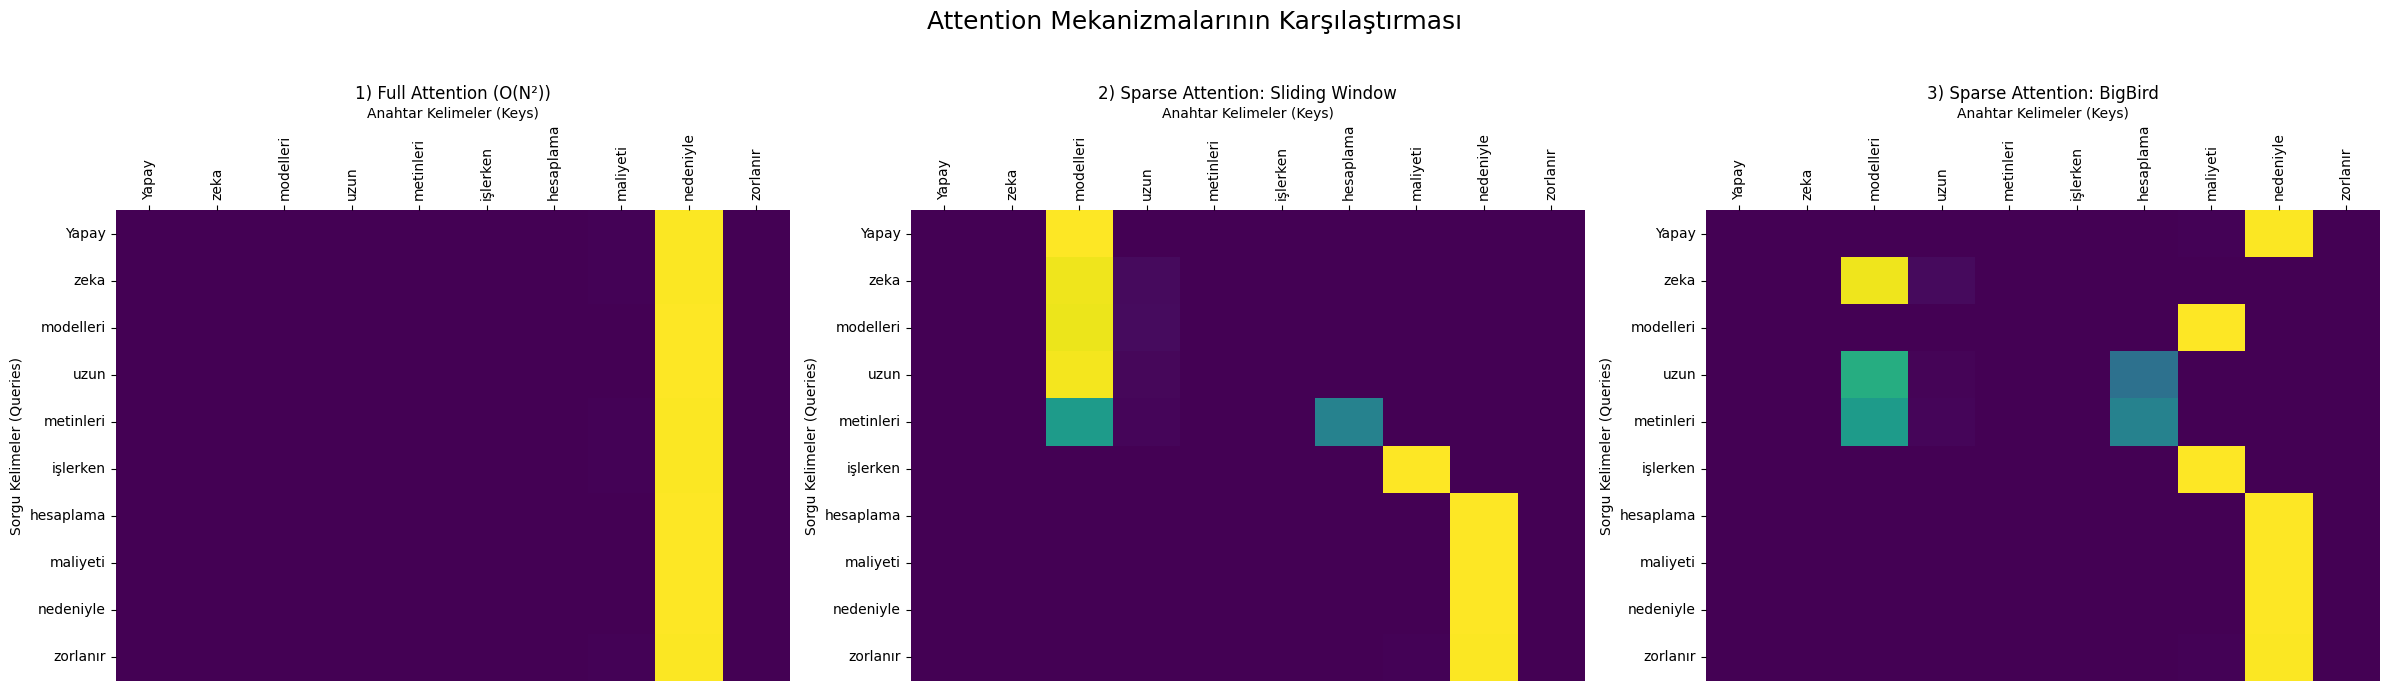

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --- Önceki kodlardan alınan yardımcı fonksiyonlar ---
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

# --- BigBird için yeni maske oluşturma fonksiyonları ---

def create_sliding_window_mask(sequence_length, window_size):
    """Kayan pencere için maske oluşturur."""
    mask = np.full((sequence_length, sequence_length), -np.inf)
    for i in range(sequence_length):
        start = max(0, i - window_size)
        end = min(sequence_length, i + window_size + 1)
        mask[i, start:end] = 0
    return mask

def create_random_mask(sequence_length, num_random_tokens, window_size):
    """Rastgele dikkat için maske oluşturur."""
    mask = np.full((sequence_length, sequence_length), -np.inf)
    for i in range(sequence_length):
        # Rastgele indisleri seç
        random_indices = np.random.choice(sequence_length, num_random_tokens, replace=False)
        mask[i, random_indices] = 0
    return mask

def create_global_mask(sequence_length, global_indices):
    """Genel dikkat için maske oluşturur."""
    mask = np.full((sequence_length, sequence_length), -np.inf)
    # Global token'ların olduğu satır ve sütunları tamamen aç
    mask[global_indices, :] = 0
    mask[:, global_indices] = 0
    return mask

# --- YENİ 3'LÜ KARŞILAŞTIRMA GÖRSELLEŞTİRME FONKSİYONU ---
def visualize_bigbird_comparison(sentence, full_att, window_att, bigbird_att):
    """Üç dikkat matrisini yan yana görselleştirir."""
    try:
        font_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', size=9)
        plt.rcParams['font.family'] = font_prop.get_name()
    except:
        print("\nUyarı: 'DejaVu Sans' fontu bulunamadı. Görseldeki etiketler düzgün görünmeyebilir.\n")
    
    tokens = sentence.split()
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    
    # Grafik 1: Full Attention
    sns.heatmap(full_att, xticklabels=tokens, yticklabels=tokens, annot=False, cmap="viridis", ax=axes[0], cbar=False)
    axes[0].set_title("1) Full Attention (O(N²))")
    
    # Grafik 2: Sliding Window Attention
    sns.heatmap(window_att, xticklabels=tokens, yticklabels=tokens, annot=False, cmap="viridis", ax=axes[1], cbar=False)
    axes[1].set_title("2) Sparse Attention: Sliding Window")

    # Grafik 3: BigBird Attention
    sns.heatmap(bigbird_att, xticklabels=tokens, yticklabels=tokens, annot=False, cmap="viridis", ax=axes[2], cbar=False)
    axes[2].set_title("3) Sparse Attention: BigBird")

    for ax in axes:
        ax.set_xlabel("Anahtar Kelimeler (Keys)")
        ax.set_ylabel("Sorgu Kelimeler (Queries)")
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        plt.setp(ax.get_xticklabels(), rotation=90)


    fig.suptitle("Attention Mekanizmalarının Karşılaştırması", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def bigbird_attention_demo(sentence, window_size=1, num_random_tokens=1, global_indices=[0]):
    """
    Full, Sliding Window ve BigBird Attention mekanizmalarını karşılaştırır.
    """
    print(f"'{sentence}' cümlesi için Attention Mekanizmaları Analizi")
    print(f"BigBird Parametreleri -> Pencere: {window_size}, Rastgele: {num_random_tokens}, Genel: {global_indices}")
    print("=" * 80)
    
    tokens = sentence.split()
    seq_len = len(tokens)
    
    # Adım 1-4: Ortak Hesaplamalar
    d_model, d_k = 32, 8
    np.random.seed(42)
    embeddings = np.random.rand(seq_len, d_model)
    W_q, W_k, W_v = [np.random.rand(d_model, d_k) for _ in range(3)]
    Q, K, V = embeddings @ W_q, embeddings @ W_k, embeddings @ W_v
    scaled_scores = (Q @ K.T) / np.sqrt(d_k)
    
    # 1. YOL: FULL ATTENTION
    full_attention_weights = softmax(scaled_scores)
    
    # 2. YOL: SLIDING WINDOW ATTENTION
    window_mask = create_sliding_window_mask(seq_len, window_size)
    window_attention_weights = softmax(scaled_scores + window_mask)
    
    # 3. YOL: BIGBIRD ATTENTION
    print("BigBird Maskesi Oluşturuluyor...")
    # Üç farklı maskeyi oluştur
    mask1_window = create_sliding_window_mask(seq_len, window_size)
    mask2_random = create_random_mask(seq_len, num_random_tokens, window_size)
    mask3_global = create_global_mask(seq_len, global_indices)
    
    # Maskeleri birleştir. Bir pozisyona herhangi bir maske izin veriyorsa (0 ise),
    # o pozisyon açık kalmalıdır.
    bigbird_mask = np.maximum.reduce([mask1_window, mask2_random, mask3_global])
    
    # BigBird ağırlıklarını hesapla
    bigbird_attention_weights = softmax(scaled_scores + bigbird_mask)
    
    print("Analiz tamamlandı. Karşılaştırma grafiği oluşturuluyor...")
    
    # Sonuçları görselleştir
    visualize_bigbird_comparison(sentence, full_attention_weights, window_attention_weights, bigbird_attention_weights)


if __name__ == '__main__':
    ornek_cumle = "Yapay zeka modelleri uzun metinleri işlerken hesaplama maliyeti nedeniyle zorlanır"
    
    # BigBird Parametreleri
    pencere_boyutu = 2       # Her kelime sağına/soluna 2 kelimeye bakar
    rastgele_token_sayisi = 2 # Her kelime rastgele 2 kelimeye daha bakar
    genel_token_indisleri = [0] # İlk kelime ('Yapay') genel token'dır
    
    bigbird_attention_demo(ornek_cumle, pencere_boyutu, rastgele_token_sayisi, genel_token_indisleri)

# 4. Flash Attention

In [9]:
import numpy as np

def naive_attention(Q, K, V):
    """Standart, basit ve verimsiz attention hesaplaması."""
    print("--- 1) Naif (Standart) Attention Hesaplanıyor ---")
    d_k = Q.shape[-1]
    
    # Tüm matrisler üzerinde tek seferde işlem yapılır
    scores = (Q @ K.T) / np.sqrt(d_k)
    weights = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    weights /= np.sum(weights, axis=-1, keepdims=True)
    output = weights @ V
    
    print("Naif Attention tamamlandı. Sonuç hafızada.\n")
    return output

def flash_attention_detailed_steps(Q, K, V, block_size):
    """
    FlashAttention'ın mantığını, ara adımları detaylı bir şekilde basarak simüle eder.
    BU BİR PERFORMANS OPTİMİZASYONU DEĞİL, KAVRAMSAL BİR SİMÜLASYONDUR.
    """
    print(f"--- 2) FlashAttention (Detaylı Adımlar) Hesaplanıyor (Blok Boyutu: {block_size}) ---")
    
    seq_len, d_k = Q.shape
    output = np.zeros_like(Q)
    
    num_blocks = seq_len // block_size
    
    # Sadece ilk satırın (ilk kelimenin) evrimini takip edeceğiz
    trace_row_index = 0

    # Q matrisini bloklara ayır (Dış Döngü)
    for i in range(num_blocks):
        start_i, end_i = i * block_size, (i + 1) * block_size
        Q_block = Q[start_i:end_i, :]
        
        # Bu Q bloğu için çıktı ve istatistikleri başlat
        O_block = np.zeros_like(Q_block)
        l_block = np.zeros(block_size)
        m_block = np.full(block_size, -np.inf)
        
        print(f"\n[Dış Döngü] Q'nun {i+1}. bloğu işleniyor (Satır {start_i}-{end_i-1})...")
        if start_i <= trace_row_index < end_i:
            print(f"  Takip edilen satır ({trace_row_index}) için başlangıç durumu:")
            print(f"    m (max skor) = {m_block[trace_row_index - start_i]:.2f}, l (norm. faktör) = {l_block[trace_row_index - start_i]:.2f}")
            print(f"    O (çıktı)    = {np.round(O_block[trace_row_index - start_i], 2)}")

        # K ve V matrislerini bloklara ayır (İç Döngü)
        for j in range(num_blocks):
            start_j, end_j = j * block_size, (j + 1) * block_size
            K_block = K[start_j:end_j, :]
            V_block = V[start_j:end_j, :]
            
            # --- SRAM İÇİNDEKİ HESAPLAMALAR ---
            S_ij = (Q_block @ K_block.T) / np.sqrt(d_k)
            
            # Online Softmax güncellemesi
            m_old = m_block
            l_old = l_block
            O_old = np.copy(O_block) # Karşılaştırma için kopyala
            
            m_new = np.maximum(m_old, np.max(S_ij, axis=1))
            P_ij = np.exp(S_ij - m_new[:, np.newaxis])
            exp_m_diff = np.exp(m_old - m_new)
            
            l_new = exp_m_diff * l_old + np.sum(P_ij, axis=1)
            
            # O vektörünü güncelle: Eski değeri yeniden ölçeklendir ve yeni değeri ekle
            O_block = O_old * exp_m_diff[:, np.newaxis]
            O_block += (P_ij @ V_block)
            
            # Bir sonraki döngü için m ve l'yi güncelle
            m_block = m_new
            l_block = l_new
            
            if start_i <= trace_row_index < end_i:
                print(f"  [İç Döngü] K/V'nin {j+1}. bloğu işlendi:")
                print(f"    m güncellendi: {m_old[trace_row_index - start_i]:.2f} -> {m_new[trace_row_index - start_i]:.2f}")
                print(f"    l güncellendi: {l_old[trace_row_index - start_i]:.2f} -> {l_new[trace_row_index - start_i]:.2f}")
                print(f"    O güncellendi: {np.round(O_old[trace_row_index - start_i, :4], 2)} -> {np.round(O_block[trace_row_index - start_i, :4], 2)}")

        # Bu Q bloğu için tüm hesaplamalar bitti, nihai sonucu HBM'e yaz
        output[start_i:end_i, :] = O_block / l_block[:, np.newaxis]

    print("\nTüm bloklar işlendi. FlashAttention tamamlandı.\n")
    return output

if __name__ == '__main__':
    # Parametreler
    SEQUENCE_LENGTH = 128 
    D_MODEL = 64
    BLOCK_SIZE = 32 

    # Rastgele Q, K, V matrisleri oluştur
    np.random.seed(42)
    Q = np.random.randn(SEQUENCE_LENGTH, D_MODEL)
    K = np.random.randn(SEQUENCE_LENGTH, D_MODEL)
    V = np.random.randn(SEQUENCE_LENGTH, D_MODEL)

    # 1. Yöntem: Standart Yaklaşım (Referans sonuç)
    output_naive = naive_attention(Q, K, V)
    
    # 2. Yöntem: FlashAttention Adım Adım Simülasyonu
    output_flash = flash_attention_detailed_steps(Q, K, V, BLOCK_SIZE)
    
    # 3. Sonuçları Karşılaştırma
    print("--- 3) Sonuçların Karşılaştırılması ---")
    are_same = np.allclose(output_naive, output_flash, atol=1e-6)
    
    print(f"Naif Attention ve FlashAttention sonuçları matematiksel olarak aynı mı? -> {are_same}")
    if are_same:
        print("Kanıt: Adım adım ilerleyen 'online' güncelleme mekanizması, tek seferde yapılan hesaplama ile aynı sonucu vermiştir.")
    else:
        print("Hata: Sonuçlar farklı, simülasyonda bir sorun var.")

    print("\nNihai Çıktı Karşılaştırması (ilk satır):")
    print("Naif  :", np.round(output_naive[0, :5], 4))
    print("Flash :", np.round(output_flash[0, :5], 4))

--- 1) Naif (Standart) Attention Hesaplanıyor ---
Naif Attention tamamlandı. Sonuç hafızada.

--- 2) FlashAttention (Detaylı Adımlar) Hesaplanıyor (Blok Boyutu: 32) ---

[Dış Döngü] Q'nun 1. bloğu işleniyor (Satır 0-31)...
  Takip edilen satır (0) için başlangıç durumu:
    m (max skor) = -inf, l (norm. faktör) = 0.00
    O (çıktı)    = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [İç Döngü] K/V'nin 1. bloğu işlendi:
    m güncellendi: -inf -> 1.69
    l güncellendi: 0.00 -> 7.83
    O güncellendi: [0. 0. 0. 0.] -> [-4.61  2.12  0.68 -0.24]
  [İç Döngü] K/V'nin 2. bloğu işlendi:
    m güncellendi: 1.69 -> 1.69
    l güncellendi: 7.83 -> 15.34
    O güncellendi: [-4.61  2.12  0.68 -0.24] -> [-2.96  3.25 -1.54 -1.71]
  [İç Döngü] K/V'nin 3. bloğu işlendi:
    m güncellendi: 1.69 -> 2.01
    l güncellendi: 15.34 -> 17.04
    O güncellendi

# 5. Multi Head Attention

**Senaryo (Örnek) : **

Multi-Head Attention: Aynı cümleyi okuyan bir uzmanlar komitesi gibidir.

Kafa 1 (Dilbilgisi Uzmanı): Sadece cümlenin dilbilgisi yapısına, özne-yüklem uyumuna bakar.

Kafa 2 (Anlam Uzmanı): Kelimelerin anlamsal yakınlığına, eş ve zıt anlamlılarına odaklanır.

Kafa 3 (Bağlam Uzmanı): Zamirlerin kimi işaret ettiğine ("o", "bunu" vb.) veya cümlenin genel akışına bakar.

Her uzman (kafa), aynı metne bakar ancak kendi uzmanlık filtresinden (kendi W_q, W_k, W_v seti) geçirerek analiz eder. Sonunda, tüm uzmanların raporları birleştirilerek cümlenin çok daha zengin ve çok yönlü bir analizi ortaya çıkar.

**Farklılaşma Nerede Oluyor?**

Her kafanın Q, K, V matrislerinin farklı olmasının sebebi, her kafa için ayrı ve bağımsız Ağırlık Matrisleri (W_q, W_k, W_v) öğrenilmesidir. Farklılaşma tam olarak bu noktada başlar. Model, her kafanın farklı bir ilişki türünü öğrenmesi için onu farklı ağırlık setleriyle donatır.

In [10]:
import numpy as np

# --- Adım 0: Temel Ayarlar ve Hiperparametreler ---
print("--- Adım 0: Ayarlar ve Hiperparametreler ---")
ornek_metin = "akıllı köpek kırmızı topu kovaladı"
tokenler = ornek_metin.split()
print(f"Girdi Metni: '{ornek_metin}'\n")

# Modelin genel vektör boyutu
d_model = 6
# Kullanılacak kafa sayısı
num_heads = 6

# d_model, kafa sayısına tam bölünmeli. Bu bir mimari kuralıdır.
# Her kafa daha küçük bir boyutta çalışır.
d_k = d_model // num_heads

print(f"Model Boyutu (d_model): {d_model}")
print(f"Kafa Sayısı (num_heads): {num_heads}")
print(f"Her Kafanın Boyutu (d_k): {d_model} / {num_heads} = {d_k}\n")

# Tekrarlanabilirlik için
np.random.seed(42)

# Giriş kelimeleri için embedding'ler (tek ve ortak)
X = np.round(np.random.rand(len(tokenler), d_model), 2)
print(f"Ortak Giriş Embedding Matrisi X (boyut: {X.shape}):\n{X}\n")
print("="*60)

# --- Adım 1: Her Kafa İçin Ayrı Ağırlık Matrisleri Oluşturma ---
print("\n--- Adım 1: Her Kafa İçin AYRI Ağırlık Matrisleri Oluşturma ---")
print("Farklılaşmanın başladığı yer tam olarak burasıdır!")
print(f"{num_heads} kafa olduğu için, {num_heads} set ayrı W_q, W_k, W_v matrisi oluşturulur.\n")

kafa_agirliklari = {}
for i in range(num_heads):
    kafa_agirliklari[f'kafa_{i+1}'] = {
        'W_q': np.round(np.random.rand(d_model, d_k), 2),
        'W_k': np.round(np.random.rand(d_model, d_k), 2),
        'W_v': np.round(np.random.rand(d_model, d_k), 2)
    }

# Oluşturulan ağırlıkları gösterelim
for i in range(num_heads):
    print(f"--- BAŞLIK {i+1} AĞIRLIKLARI ---")
    print(f"W_q_{i+1} (boyut: {kafa_agirliklari[f'kafa_{i+1}']['W_q'].shape}):\n{kafa_agirliklari[f'kafa_{i+1}']['W_q']}\n")
    print(f"W_k_{i+1} (boyut: {kafa_agirliklari[f'kafa_{i+1}']['W_k'].shape}):\n{kafa_agirliklari[f'kafa_{i+1}']['W_k']}\n")
    
print("Gördüğünüz gibi, her kafanın kendine özgü, rastgele başlatılmış ağırlıkları var.")
print("Eğitim sırasında bu ağırlıklar farklılaşarak farklı görevlerde uzmanlaşır.")
print("="*60)


# --- Adım 2: Her Kafanın Paralel Olarak Kendi Q,K,V'sini Hesaplaması ---
print("\n--- Adım 2: Her Kafa, AYNI GİRDİYİ Kendi Ağırlıklarıyla İşliyor ---")

kafa_ciktilari = {}

for i in range(num_heads):
    kafa_adi = f'kafa_{i+1}'
    print(f"\n--- BAŞLIK {i+1} İŞLEMDE ---")
    
    # İlgili kafanın ağırlıklarını al
    W_q = kafa_agirliklari[kafa_adi]['W_q']
    W_k = kafa_agirliklari[kafa_adi]['W_k']
    W_v = kafa_agirliklari[kafa_adi]['W_v']
    
    # ORTAK GİRDİ (X) ile bu kafaya ÖZEL ağırlıkları çarparak Q, K, V'yi oluştur
    print(f"Ortak X matrisi, BAŞLIK {i+1}'e özel W_q, W_k, W_v ile çarpılıyor...")
    Q = np.dot(X, W_q)
    K = np.dot(X, W_k)
    V = np.dot(X, W_v)
    
    print(f"\nBAŞLIK {i+1} için üretilen Q Matrisi (boyut: {Q.shape}):\n{np.round(Q, 2)}")
    print(f"BAŞLIK {i+1} için üretilen K Matrisi (boyut: {K.shape}):\n{np.round(K, 2)}")
    print(f"BAŞLIK {i+1} için üretilen V Matrisi (boyut: {V.shape}):\n{np.round(V, 2)}")
    
    # Bu kafanın dikkat skorlarını ve çıktısını hesapla
    skorlar = np.dot(Q, K.T) / np.sqrt(d_k)
    dikkat_agirliklari = np.exp(skorlar) / np.sum(np.exp(skorlar), axis=-1, keepdims=True)
    
    # Her kafanın kendi dikkat çıktısı var
    kafa_ciktisi = np.dot(dikkat_agirliklari, V)
    kafa_ciktilari[kafa_adi] = kafa_ciktisi
    
    print(f"\nBAŞLIK {i+1}'in kendi dikkat çıktısı (boyut: {kafa_ciktisi.shape}):\n{np.round(kafa_ciktisi, 2)}")
    
print("\nFarklı ağırlıklar nedeniyle her kafanın ürettiği Q, K, V matrisleri ve sonuçta ürettiği dikkat çıktısı birbirinden farklıdır.")
print("="*60)

# --- Adım 3: Kafalardan Gelen Çıktıları Birleştirme ve Final Çıktı ---
print("\n--- Adım 3: Kafaların Raporlarını (Çıktılarını) Birleştirme ---")

# Her kafadan gelen (5, 3) boyutundaki çıktıları yanyana birleştir (concatenate)
# Sonuçta (5, 6) yani (token_sayisi, d_model) boyutunda bir matris elde ederiz.
birlesik_cikti = np.concatenate(list(kafa_ciktilari.values()), axis=1)
print(f"Tüm kafa çıktılarının birleştirilmiş hali (boyut: {birlesik_cikti.shape}):\n{np.round(birlesik_cikti, 2)}\n")

# Son bir dokunuş: Bu birleşik çıktı, genellikle son bir ağırlık matrisi (W_o) ile daha çarpılır.
# Bu matris, farklı kafalardan gelen bilgileri harmanlamayı öğrenir.
W_o = np.round(np.random.rand(d_model, d_model), 2)
print(f"Tüm bilgileri harmanlayan final Ağırlık Matrisi W_o (boyut: {W_o.shape}):\n{W_o}\n")

final_cikti = np.dot(birlesik_cikti, W_o)
print(f"Multi-Head Attention Katmanının FİNAL ÇIKTISI (boyut: {final_cikti.shape}):\n{np.round(final_cikti, 2)}")

--- Adım 0: Ayarlar ve Hiperparametreler ---
Girdi Metni: 'akıllı köpek kırmızı topu kovaladı'

Model Boyutu (d_model): 6
Kafa Sayısı (num_heads): 6
Her Kafanın Boyutu (d_k): 6 / 6 = 1

Ortak Giriş Embedding Matrisi X (boyut: (5, 6)):
[[0.37 0.95 0.73 0.6  0.16 0.16]
 [0.06 0.87 0.6  0.71 0.02 0.97]
 [0.83 0.21 0.18 0.18 0.3  0.52]
 [0.43 0.29 0.61 0.14 0.29 0.37]
 [0.46 0.79 0.2  0.51 0.59 0.05]]


--- Adım 1: Her Kafa İçin AYRI Ağırlık Matrisleri Oluşturma ---
Farklılaşmanın başladığı yer tam olarak burasıdır!
6 kafa olduğu için, 6 set ayrı W_q, W_k, W_v matrisi oluşturulur.

--- BAŞLIK 1 AĞIRLIKLARI ---
W_q_1 (boyut: (6, 1)):
[[0.61]
 [0.17]
 [0.07]
 [0.95]
 [0.97]
 [0.81]]

W_k_1 (boyut: (6, 1)):
[[0.3 ]
 [0.1 ]
 [0.68]
 [0.44]
 [0.12]
 [0.5 ]]

--- BAŞLIK 2 AĞIRLIKLARI ---
W_q_2 (boyut: (6, 1)):
[[0.55]
 [0.18]
 [0.97]
 [0.78]
 [0.94]
 [0.89]]

W_k_2 (boyut: (6, 1)):
[[0.6 ]
 [0.92]
 [0.09]
 [0.2 ]
 [0.05]
 [0.33]]

--- BAŞLIK 3 AĞIRLIKLARI ---
W_q_3 (boyut: (6, 1)):
[[0.14]
 [0.8

## 5.1. MHA Örnek metin üzerinde çalışması

In [11]:
import numpy as np

# --- Adım 0: Ayarlar ve "Eğitilmiş" Model ---
print("--- Adım 0: Ayarlar ve 'Eğitilmiş' Multi-Head Model ---")
# Hiperparametreler
d_model = 8  # Modelin ana boyutu
num_heads = 2  # Kullanacağımız kafa sayısı
d_k = d_model // num_heads # Her kafanın kendi çalışma boyutu

print(f"Model Boyutu (d_model): {d_model}, Kafa Sayısı: {num_heads}, Her Kafa Boyutu (d_k): {d_k}\n")
np.random.seed(42) # Tekrarlanabilirlik için

# Her kafa için ayrı "eğitilmiş" ağırlık matrisleri
kafa_agirliklari = {}
for i in range(num_heads):
    kafa_agirliklari[f'kafa_{i+1}'] = {
        'W_q': np.round(np.random.rand(d_model, d_k), 2),
        'W_k': np.round(np.random.rand(d_model, d_k), 2),
        'W_v': np.round(np.random.rand(d_model, d_k), 2)
    }
print("Her kafa için ayrı W_q, W_k, W_v setleri yüklendi.\n")
print("="*60)


# --- Adım 1: Bilgi Bankasını (Context) İşleme ---
print("\n--- Adım 1: Bilgi Bankasının Her Kafa Tarafından Ayrı Ayrı İşlenmesi ---")
bilgi_bankasi_metni = "zeki siyah köpek tembel beyaz kediyi hızla kovaladı turkcell ile baglan hayata"
context_tokenler = bilgi_bankasi_metni.split()
print(f"Bilgi Bankası Metni: '{bilgi_bankasi_metni}'\n")

# Ortak girdi embedding matrisi
X_context = np.round(np.random.rand(len(context_tokenler), d_model), 2)

# Her kafanın kendi "hafızasını" (K ve V matrislerini) oluşturması
context_hafizasi = {}
for i in range(num_heads):
    kafa_adi = f'kafa_{i+1}'
    W_k = kafa_agirliklari[kafa_adi]['W_k']
    W_v = kafa_agirliklari[kafa_adi]['W_v']
    
    # Her kafa, ortak X_context'i kendi K ve V ağırlıklarıyla çarpar
    K_context = np.dot(X_context, W_k)
    V_context = np.dot(X_context, W_v)
    context_hafizasi[kafa_adi] = {'K': K_context, 'V': V_context}
    
    print(f"--- BAŞLIK {i+1}'in Hafızası ---")
    print(f"K_context_{i+1} (boyut: {K_context.shape}):\n{np.round(K_context, 2)}")
    print(f"V_context_{i+1} (boyut: {V_context.shape}):\n{np.round(V_context, 2)}\n")
print("Gördüğünüz gibi, her kafa bilgi bankasını kendi perspektifinden 'anladı' ve hafızasına kaydetti.")
print("="*60)


# --- Adım 2: Soruyu İşleme ve Cevap Bulma ---
print("\n--- Adım 2: Soru Geldi ve Her Kafa Cevap İçin Çalışıyor ---")
soru_metni = "turkcell ne yaptı"
sorgu_kelimesi = "turkcell"
print(f"Soru: '{soru_metni}'\nOdaklanılan Sorgu Kelimesi: '{sorgu_kelimesi}'\n")

# Soru için embedding
soru_token_index = 2 # "köpek" kelimesinin soru metninde olmadığını varsayalım, sadece anahtar kelime var.
# Normalde soru da embedding'den geçer, biz direkt X_context'ten alarak simüle edelim.
X_soru_kelimesi = X_context[soru_token_index] 

# Her kafa, soru kelimesi için kendi Q vektörünü üretir
soru_sorgulari = {}
for i in range(num_heads):
    kafa_adi = f'kafa_{i+1}'
    W_q = kafa_agirliklari[kafa_adi]['W_q']
    Q_vektoru = np.dot(X_soru_kelimesi, W_q)
    soru_sorgulari[kafa_adi] = Q_vektoru

# --- Adım 3: Her Kafanın Dikkatini Analiz Etme ---
print("\n--- Adım 3: Her Kafanın 'Düşünme Süreci' ve Cevabı ---")

final_cevaplar = {}
for i in range(num_heads):
    kafa_adi = f'kafa_{i+1}'
    print(f"\n########### BAŞLIK {i+1} Analiz Ediyor ###########\n")
    
    # 1. Kendi Soru Vektörünü (Q) ve Hafızasındaki Anahtar Vektörlerini (K) al
    Q_soru = soru_sorgulari[kafa_adi]
    K_context = context_hafizasi[kafa_adi]['K']
    print(f"1. BAŞLIK {i+1}, kendi ürettiği '{sorgu_kelimesi}' Q Vektörünü aldı: {np.round(Q_soru, 2)}")
    print("   ve bunu kendi hafızasındaki K matrisi ile karşılaştıracak.")
    
    # 2. Dikkat Skorlarını Hesapla
    dikkat_skorlari = np.dot(Q_soru, K_context.T)
    print("\n2. Dikkat Skorları (Sorgunun hafızadaki her kelimeyle ilgisi):")
    skor_raporu = "   " + "  ".join([f"'{token}':{skor:.2f}" for token, skor in zip(context_tokenler, dikkat_skorlari)])
    print(skor_raporu)

    # 3. Softmax ile Olasılıkları Bul
    dikkat_agirliklari = np.exp(dikkat_skorlari) / np.sum(np.exp(dikkat_skorlari))
    print("\n3. Softmax Ağırlıkları (Bu kafa en çok nereye odaklandı?):")
    agirlik_raporu = "   " + "  ".join([f"'{token}':{agirlik:.3f}" for token, agirlik in zip(context_tokenler, dikkat_agirliklari)])
    print(agirlik_raporu)
    
    # 4. Bu Kafanın Cevabını Bul
    cevap_index = np.argmax(dikkat_agirliklari)
    cevap_kelimesi = context_tokenler[cevap_index]
    final_cevaplar[kafa_adi] = cevap_kelimesi
    
    print(f"\n>>> BAŞLIK {i+1}'in Cevabı: '{cevap_kelimesi}' <<<")

print("\n\n================= FİNAL SONUÇ =================\n")
print(f"Soru: '{soru_metni}'")
print("\nModelin 'Uzmanlar Komitesi' (Her Kafa) şu sonuçlara ulaştı:")
for kafa, cevap in final_cevaplar.items():
    print(f"- {kafa.replace('_', ' ').capitalize()}: '{sorgu_kelimesi}' kelimesi en çok '{cevap}' kelimesiyle ilgili.")

print("\nÖZET: Farklı kafalar, farklı ağırlık setleri nedeniyle farklı özelliklere odaklandı.")
print("Bu örnekte, bir kafa eyleme ('kovaladı') odaklanırken, bir diğeri sıfata veya başka bir ilişkiye odaklanabilirdi.")
print("Gerçek bir LLM, bu farklı dikkat çıktılarından gelen zenginleştirilmiş 'Değer' (V) vektörlerini birleştirerek")
print(" 'Köpek, kediyi kovaladı.' gibi tam bir cümle üretir.")

--- Adım 0: Ayarlar ve 'Eğitilmiş' Multi-Head Model ---
Model Boyutu (d_model): 8, Kafa Sayısı: 2, Her Kafa Boyutu (d_k): 4

Her kafa için ayrı W_q, W_k, W_v setleri yüklendi.


--- Adım 1: Bilgi Bankasının Her Kafa Tarafından Ayrı Ayrı İşlenmesi ---
Bilgi Bankası Metni: 'zeki siyah köpek tembel beyaz kediyi hızla kovaladı turkcell ile baglan hayata'

--- BAŞLIK 1'in Hafızası ---
K_context_1 (boyut: (12, 4)):
[[2.02 2.64 3.36 3.47]
 [0.93 1.61 2.11 1.92]
 [1.02 1.28 1.35 1.97]
 [1.6  2.02 2.41 2.83]
 [1.66 2.04 2.27 3.12]
 [0.7  1.42 1.59 1.76]
 [1.86 2.87 3.1  3.56]
 [1.46 2.02 3.13 2.83]
 [1.86 2.48 3.07 3.27]
 [1.41 2.43 2.83 3.15]
 [1.95 2.58 3.5  3.57]
 [0.84 1.51 2.19 2.1 ]]
V_context_1 (boyut: (12, 4)):
[[2.86 3.02 2.58 2.77]
 [2.   1.42 1.32 1.19]
 [1.99 1.61 1.41 1.33]
 [1.91 2.36 2.32 1.64]
 [2.45 2.62 2.29 2.28]
 [1.72 1.6  1.18 1.37]
 [2.05 3.28 3.13 3.03]
 [2.04 2.65 2.1  1.85]
 [1.75 2.74 2.46 2.35]
 [2.58 2.98 2.49 2.63]
 [2.82 3.31 2.8  2.66]
 [1.69 2.03 1.38 1.73]]

--

## 5.2. MHA Özet Örnek Kod

In [12]:
import torch
import torch.nn.functional as F
import numpy as np

def single_head_attention(Q, K, V):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(d_k)
    weights = F.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    return output, weights

def multi_head_attention(Q, K, V, num_heads):
    batch_size, seq_len, d_model = Q.size()
    assert d_model % num_heads == 0, "d_model num_heads'e tam bölünmelidir"
    d_k = d_model // num_heads

    # Lineer projeksiyonlar (başlık sayısı kadar)
    Q = Q.view(batch_size, seq_len, num_heads, d_k).transpose(1, 2)  # (B, h, S, d_k)
    K = K.view(batch_size, seq_len, num_heads, d_k).transpose(1, 2)
    V = V.view(batch_size, seq_len, num_heads, d_k).transpose(1, 2)

    scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(d_k)
    weights = F.softmax(scores, dim=-1)
    print("Her head için attention score matrisleri:")
    for i, head_weights in enumerate(weights[0]):
        print(f"\nHead {i+1}:")
        print(np.round(head_weights.detach().numpy(), 2))

    attended = torch.matmul(weights, V)  # (B, h, S, d_k)
    concat = attended.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
    return concat, weights

# Simülasyon: 1 örnek, 4 kelime, 8 boyutlu embedding
torch.manual_seed(42)
x = torch.randn(1, 4, 8)  # (batch, seq_len, d_model)

# Tek başlı attention
Q = K = V = x.clone()
output_single, weights_single = single_head_attention(Q[0], K[0], V[0])
print("\n--- Tek Başlı Attention ---")
print("Attention çıktısı:", np.round(output_single.detach().numpy(), 2))

# Çok başlı attention (2 head)
print("\n--- Multi-Head Attention (2 Head) ---")
output_multi, weights_multi = multi_head_attention(Q, K, V, num_heads=2)
print("MHA Çıktısı:", np.round(output_multi[0].detach().numpy(), 2))



--- Tek Başlı Attention ---
Attention çıktısı: [[ 1.9   1.49  0.89 -2.08  0.66 -1.22 -0.05 -1.57]
 [-0.18  1.54 -0.16 -1.28 -0.5  -0.56 -0.58  0.47]
 [ 1.53  0.13 -0.31  0.49 -0.66  0.84  0.59  1.48]
 [ 1.28  0.99  0.3   0.66 -0.32  0.15 -0.02  0.85]]

--- Multi-Head Attention (2 Head) ---
Her head için attention score matrisleri:

Head 1:
[[0.96 0.02 0.01 0.01]
 [0.28 0.68 0.02 0.03]
 [0.21 0.04 0.47 0.29]
 [0.13 0.03 0.14 0.7 ]]

Head 2:
[[0.89 0.06 0.01 0.04]
 [0.1  0.43 0.21 0.26]
 [0.01 0.08 0.79 0.12]
 [0.08 0.29 0.36 0.27]]
MHA Çıktısı: [[ 1.86  1.48  0.86 -2.03  0.55 -1.12 -0.08 -1.34]
 [ 0.09  1.56 -0.01 -1.49 -0.47 -0.12 -0.23  0.76]
 [ 1.51  0.67  0.12  0.09 -0.68  0.81  0.54  1.49]
 [ 1.36  1.13  0.47  0.68 -0.49  0.14 -0.    0.93]]


In [13]:
import torch
import torch.nn.functional as F
import numpy as np

# Tek başlı attention
def single_head_attention(Q, K, V):
    d_k = Q.shape[-1]
    scores = torch.matmul(Q, K.T) / np.sqrt(d_k)
    weights = F.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    return output, weights

# Çok başlı attention
def multi_head_attention(Q, K, V, num_heads=2):
    d_model = Q.shape[-1]
    assert d_model % num_heads == 0
    d_k = d_model // num_heads

    # Split and stack Q, K, V
    Q_heads = Q.reshape(Q.shape[0], num_heads, d_k)
    K_heads = K.reshape(K.shape[0], num_heads, d_k)
    V_heads = V.reshape(V.shape[0], num_heads, d_k)

    weights_all = []
    head_outputs = []
    for h in range(num_heads):
        Qh, Kh, Vh = Q_heads[:, h], K_heads[:, h], V_heads[:, h]
        scores = torch.matmul(Qh, Kh.T) / np.sqrt(d_k)
        weights = F.softmax(scores, dim=-1)
        output = torch.matmul(weights, Vh)
        weights_all.append(weights.unsqueeze(1))
        head_outputs.append(output)
    
    # Concatenate head outputs
    final_output = torch.cat(head_outputs, dim=-1)
    all_weights = torch.cat(weights_all, dim=1)
    return final_output, all_weights

# Soru ve bağlam
tokens = ["türkiye", "ankara", "başkent", "neresidir"]
context = ["türkiye", "başkent", "ankara"]
question = ["başkent", "neresidir"]

# Sözlük ve embedding
token_to_idx = {tok: i for i, tok in enumerate(tokens)}
torch.manual_seed(0)
embedding = torch.randn(len(tokens), 4)  # 4 boyutlu vektör, 2 head için

context_embed = embedding[[token_to_idx[t] for t in context]]
question_embed = embedding[[token_to_idx[t] for t in question]]

print("\n Soru:", question)
print("Bağlam:", context)

# Tek başlı attention
Q = question_embed
K = V = context_embed
single_out, single_weights = single_head_attention(Q, K, V)
print("\n🔹 Tek Başlı Attention Ağırlıkları:")
print(np.round(single_weights.detach().numpy(), 2))

# Çok başlı attention
multi_out, multi_weights = multi_head_attention(Q, K, V, num_heads=2)
print("\n Çok Başlı Attention Head 1:")
print(np.round(multi_weights[:, 0, :].detach().numpy(), 2))
print("\n Çok Başlı Attention Head 2:")
print(np.round(multi_weights[:, 1, :].detach().numpy(), 2))



 Soru: ['başkent', 'neresidir']
Bağlam: ['türkiye', 'başkent', 'ankara']

🔹 Tek Başlı Attention Ağırlıkları:
[[0.33 0.56 0.11]
 [0.15 0.2  0.65]]

 Çok Başlı Attention Head 1:
[[0.35 0.54 0.11]
 [0.13 0.13 0.75]]

 Çok Başlı Attention Head 2:
[[0.33 0.45 0.22]
 [0.27 0.38 0.35]]


# 6. Mixture of Experts (MoE) Uzmanlar Karması

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Adım: Uzman (Expert) Modülünü Tanımlama
# Her bir uzman, basit bir Feed-Forward Network (FFN) olacak.
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Basit bir iki katmanlı ağ: Linear -> ReLU -> Linear
        hidden = F.relu(self.fc1(x))
        output = self.fc2(hidden)
        return output

# 2. Adım: Yönlendirici (Gating Network) Modülünü Tanımlama
# Bu ağ, hangi uzmanın hangi token için ne kadar uygun olduğuna karar verir.
class GatingNetwork(nn.Module):
    def __init__(self, input_dim, num_experts):
        super().__init__()
        # Çıktısı, uzman sayısı kadar olan basit bir lineer katman
        self.layer = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        # Girdiyi alır ve her uzman için bir "puan" (logit) üretir.
        logits = self.layer(x)
        return logits

# 3. Adım: MoE Katmanını Bir Araya Getirme
class MoELayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_experts, top_k=2):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k

        # Uzmanları bir liste içinde oluştur
        # nn.ModuleList, PyTorch'un bu uzmanları modelin bir parçası olarak görmesini sağlar.
        self.experts = nn.ModuleList([
            Expert(input_dim, hidden_dim, output_dim) for _ in range(num_experts)
        ])
        
        # Yönlendirici ağı oluştur
        self.gating_network = GatingNetwork(input_dim, num_experts)
        print(f"{num_experts} uzmanlı ve top_k={top_k} olacak şekilde bir MoE katmanı oluşturuldu.")

    def forward(self, x):
        # x'in şekli: (batch_size, sequence_len, input_dim)
        # Eğitim kolaylığı için batch_size=1 ve sequence_len=token sayısı varsayalım.
        # x'in şekli: (num_tokens, input_dim)
        num_tokens, input_dim = x.shape

        # Adım A: Yönlendiriciden her token için uzman puanlarını al
        # gating_logits şekli: (num_tokens, num_experts)
        gating_logits = self.gating_network(x)
        
        # Adım B: Her token için en iyi k uzmanı ve onların puanlarını seç
        # torch.topk, hem değerleri (puanları) hem de indisleri döndürür.
        top_k_logits, top_k_indices = torch.topk(gating_logits, self.top_k, dim=-1)
        
        # Adım C: Seçilen k uzmanın puanlarına softmax uygulayarak ağırlıklar elde et
        # Bu ağırlıkların toplamı her token için 1 olur.
        top_k_weights = F.softmax(top_k_logits, dim=-1)

        # Adım D: Çıktıyı hesapla
        final_output = torch.zeros_like(x)

        # Her bir token için adım adım işlem yapalım (anlaşılırlık için döngü kullanıyoruz)
        print("\n--- Token Bazında Uzman Seçimi ve Hesaplama ---")
        for i in range(num_tokens):
            print(f"\nToken {i+1} için analiz:")
            print(f"  Tüm uzmanlar için ham puanlar (logits): {np.round(gating_logits[i].detach().numpy(), 2)}")
            print(f"  Seçilen en iyi {self.top_k} uzman (indisler): {top_k_indices[i].tolist()}")
            print(f"  Bu uzmanların ağırlıkları (softmax sonrası): {np.round(top_k_weights[i].detach().numpy(), 2)}")

            token_output = torch.zeros(input_dim)
            
            # Seçilen k uzmanı döngüye al
            for j in range(self.top_k):
                expert_index = top_k_indices[i, j].item()
                expert_weight = top_k_weights[i, j]
                
                # İlgili uzmandan çıktıyı al
                expert_output = self.experts[expert_index](x[i])
                
                # Ağırlıklı çıktıyı topla
                token_output += expert_weight * expert_output

                print(f"    -> Uzman {expert_index} çalıştı. Ağırlık: {expert_weight:.2f}")

            final_output[i] = token_output
        
        return final_output

if __name__ == '__main__':
    # Simülasyon için parametreler
    # Genellikle bir cümlenin embedding vektörlerinin boyutu
    input_dim = 32    
    # Her uzmanın içindeki gizli katman boyutu
    hidden_dim = 64   
    # Çıktı boyutu (girdi ile aynı)
    output_dim = 32   
    # Toplam uzman sayısı
    num_experts = 8   
    # Her token için seçilecek en iyi uzman sayısı
    top_k = 2         

    # Modeli oluştur
    moe_layer = MoELayer(input_dim, hidden_dim, output_dim, num_experts, top_k)

    # 4 farklı token'dan oluşan sahte bir girdi oluşturalım
    # (Örn: "Yapay zeka harikadır" cümlesinin token vektörleri)
    num_tokens = 4
    input_tokens = torch.randn(num_tokens, input_dim)

    # Modeli çalıştır ve çıktıyı al
    final_output = moe_layer(input_tokens)

    print("\n--- Nihai Sonuç ---")
    print(f"MoE katmanından geçen {num_tokens} token'ın nihai çıktı vektörleri:")
    # Çıktının sadece ilk 5 boyutunu gösterelim
    print(np.round(final_output[:, :5].detach().numpy(), 3))

8 uzmanlı ve top_k=2 olacak şekilde bir MoE katmanı oluşturuldu.

--- Token Bazında Uzman Seçimi ve Hesaplama ---

Token 1 için analiz:
  Tüm uzmanlar için ham puanlar (logits): [-0.65  0.28 -0.02  0.95 -0.17 -0.2   0.14  0.58]
  Seçilen en iyi 2 uzman (indisler): [3, 7]
  Bu uzmanların ağırlıkları (softmax sonrası): [0.59 0.41]
    -> Uzman 3 çalıştı. Ağırlık: 0.59
    -> Uzman 7 çalıştı. Ağırlık: 0.41

Token 2 için analiz:
  Tüm uzmanlar için ham puanlar (logits): [-0.39  0.22  0.5   0.51 -0.65 -0.42 -0.13  0.41]
  Seçilen en iyi 2 uzman (indisler): [3, 2]
  Bu uzmanların ağırlıkları (softmax sonrası): [0.5 0.5]
    -> Uzman 3 çalıştı. Ağırlık: 0.50
    -> Uzman 2 çalıştı. Ağırlık: 0.50

Token 3 için analiz:
  Tüm uzmanlar için ham puanlar (logits): [-0.29 -0.46 -0.36  0.03  0.    1.13 -0.41  0.26]
  Seçilen en iyi 2 uzman (indisler): [5, 7]
  Bu uzmanların ağırlıkları (softmax sonrası): [0.71 0.29]
    -> Uzman 5 çalıştı. Ağırlık: 0.71
    -> Uzman 7 çalıştı. Ağırlık: 0.29

Token 4 

# 7. Uçtan Uca Örnek (QnA)

               UÇTAN UCA SORU-CEVAP MODELİ SİMÜLASYONU

--- Adım 1: Girdileri Vektörlere Dönüştürme (Embedding) ---
Bağlam 'ankaranın başkent olması süreci türkiye cumhuriyetinin kuruluşuyla doğrudan bağlantılı olup hem stratejik hem de sembolik yönleriyle büyük önem taşımaktadır osmanlı imparatorluğunun 30 ekim 1918 tarihli mondros mütarekesiyle fiilen sona erdiği kabul edilen dönemde istanbul her ne kadar resmen başkent statüsünü koruyor olsa da 16 mart 1920 tarihinde itilaf devletlerinin istanbulu resmen işgal etmesiyle birlikte siyasi bir merkez olma niteliğini yitirmiştir özellikle işgal güçlerinin meclisi mebusanı dağıtması ve osmanlı hükümetini kontrol altına alması üzerine mustafa kemal paşa öncülüğünde başlayan milli mücadele hareketi anadolunun güvenli ve stratejik bir bölgesinde yeni bir merkez ihtiyacını doğurmuştur bu bağlamda 27 aralık 1919 tarihinde mustafa kemal paşanın heyeti temsiliye üyeleriyle birlikte ankaraya gelişi hem sembolik hem de pratik açıdan bir dönüm nokt

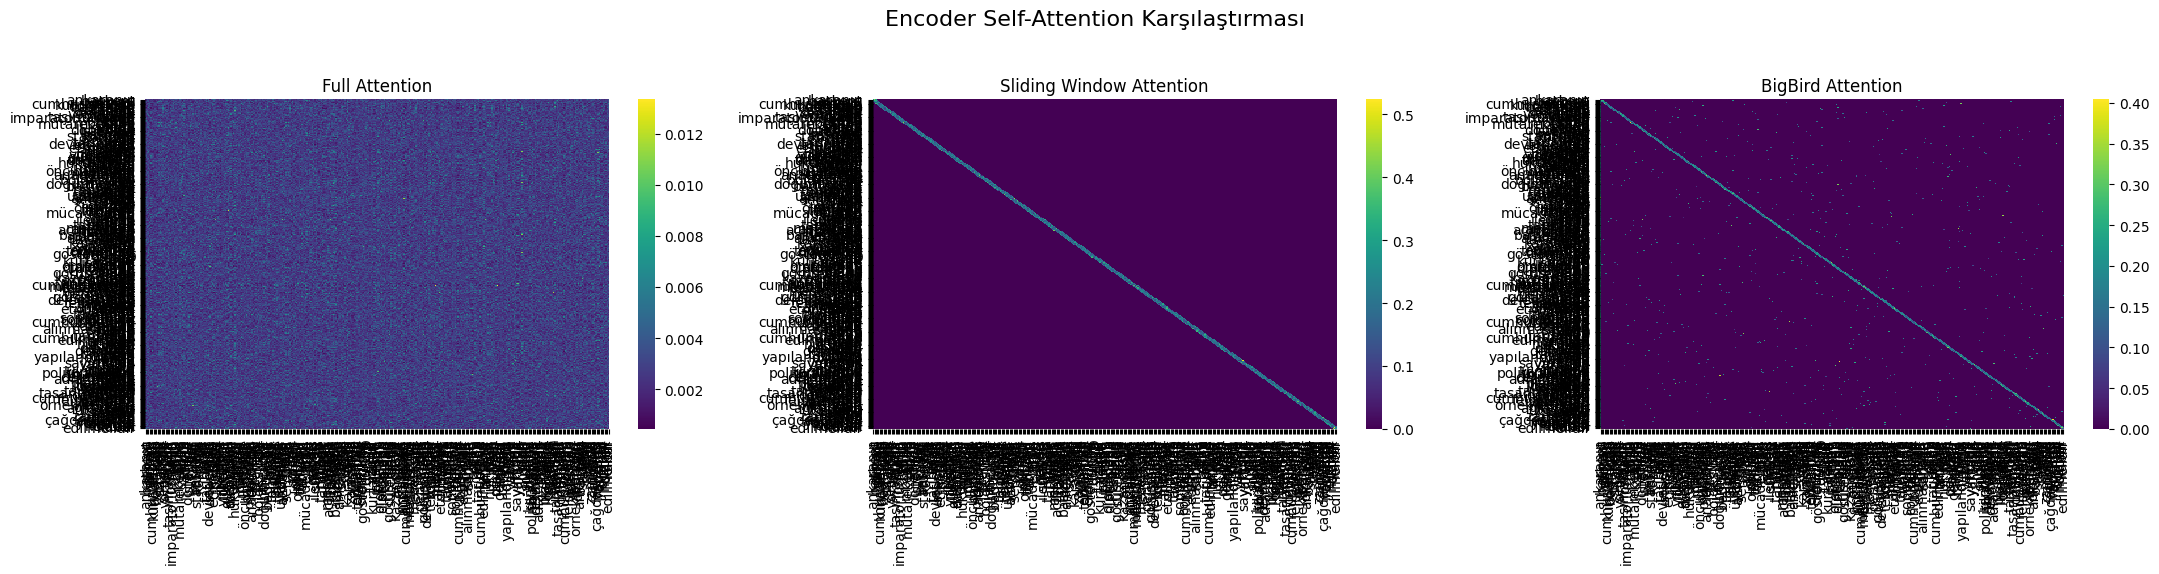


>>> FlashAttention Notu: Yukarıdaki dikkat matrislerinden herhangi biri, hesaplama sırasında
    GPU'nun yavaş HBM'i yerine hızlı SRAM'ini kullanan FlashAttention algoritması ile
    çok daha hızlı bir şekilde (sonuç değişmeden) hesaplanabilir.

Simülasyonun devamı için BigBird Attention çıktısı seçildi.

--- Adım 3: Feed-Forward Network (FFN) ---
Attention katmanından gelen bilgi, FFN katmanında 'işlenir' ve zenginleştirilir.
Standart FFN: Tüm parametreler her token için kullanılır. Maliyetli ama basittir.
Mixture of Experts: Her token için sadece en iyi 'k' uzman (toplam 4 uzmandan 2'si) çalışır.
                  Daha fazla kapasite, daha az hesaplama maliyeti demektir.
Simülasyonun devamı için MoE FFN çıktısı seçildi.

===> ENCODER AŞAMASI TAMAMLANDI. Bağlamın anlamsal temsili hazır.


============================== DECODER AŞAMASI ==============================
Amaç: Soruyu ve işlenmiş bağlamı kullanarak cevabı kelime kelime üretmek.


--- Adım 4.1: Cevabın 1. Kelimesi Üretiliyor

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# =============================================================================
# BÖLÜM 1: YARDIMCI FONKSİYONLAR VE MODÜLLER
# Önceki kodlarımızdan bildiğimiz yapı taşlarını oluşturalım.
# =============================================================================

# --- Maske oluşturma fonksiyonları ---
def create_sliding_window_mask(size, window):
    mask = torch.full((size, size), float('-inf'))
    for i in range(size):
        start, end = max(0, i - window), min(size, i + window + 1)
        mask[i, start:end] = 0
    return mask

def create_bigbird_mask(size, window, num_random, global_indices):
    # BigBird, 3 maskenin birleşimidir
    window_mask = create_sliding_window_mask(size, window)
    
    random_mask = torch.full((size, size), float('-inf'))
    for i in range(size):
        random_indices = np.random.choice(size, num_random, replace=False)
        random_mask[i, random_indices] = 0
    
    global_mask = torch.full((size, size), float('-inf'))
    global_mask[global_indices, :] = 0
    global_mask[:, global_indices] = 0
    
    # 3 maskeyi birleştir (herhangi biri izin veriyorsa, geçişe izin ver)
    combined_mask = torch.maximum(torch.maximum(window_mask, random_mask), global_mask)
    return combined_mask

# --- Dikkat ve FFN Modülleri ---
class Attention(nn.Module):
    def __init__(self, dim, n_heads=2):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        self.head_dim = dim // n_heads
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        
    def forward(self, x, mask=None):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        scores = (q @ k.transpose(-2, -1)) / np.sqrt(self.head_dim)
        if mask is not None:
            scores += mask.to(scores.device)
        
        weights = F.softmax(scores, dim=-1)
        attended = (weights @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(attended), weights

class StandardFFN(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim * 4)
        self.fc2 = nn.Linear(dim * 4, dim)

    def forward(self, x):
        return self.fc2(F.gelu(self.fc1(x)))

# --- MoE Modülleri ---
class Expert(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = StandardFFN(dim)
    def forward(self, x):
        return self.net(x)

class MoELayer(nn.Module):
    def __init__(self, dim, num_experts=4, top_k=2):
        super().__init__()
        self.experts = nn.ModuleList([Expert(dim) for _ in range(num_experts)])
        self.gating = nn.Linear(dim, num_experts)
        self.top_k = top_k
    
    def forward(self, x):
        # Sadece konsepti göstermek için basitleştirilmiş forward pass
        logits = self.gating(x)
        top_k_logits, top_k_indices = torch.topk(logits, self.top_k, dim=-1)
        weights = F.softmax(top_k_logits, dim=-1)
        
        output = torch.zeros_like(x)
        for i in range(x.size(0)): # Batch
            for j in range(x.size(1)): # Sequence
                token_input = x[i, j]
                for k in range(self.top_k):
                    expert_idx = top_k_indices[i, j, k].item()
                    weight = weights[i, j, k]
                    output[i, j] += weight * self.experts[expert_idx](token_input)
        return output

# =============================================================================
# BÖLÜM 2: UÇTAN UCA SİMÜLASYON
# =============================================================================
def run_qa_simulation():
    print("="*80)
    print(" " * 15 + "UÇTAN UCA SORU-CEVAP MODELİ SİMÜLASYONU")
    print("="*80)
    
    # --- GİRDİLER ---
    context = "ankaranın başkent olması süreci türkiye cumhuriyetinin kuruluşuyla doğrudan bağlantılı olup hem stratejik hem de sembolik yönleriyle büyük önem taşımaktadır osmanlı imparatorluğunun 30 ekim 1918 tarihli mondros mütarekesiyle fiilen sona erdiği kabul edilen dönemde istanbul her ne kadar resmen başkent statüsünü koruyor olsa da 16 mart 1920 tarihinde itilaf devletlerinin istanbulu resmen işgal etmesiyle birlikte siyasi bir merkez olma niteliğini yitirmiştir özellikle işgal güçlerinin meclisi mebusanı dağıtması ve osmanlı hükümetini kontrol altına alması üzerine mustafa kemal paşa öncülüğünde başlayan milli mücadele hareketi anadolunun güvenli ve stratejik bir bölgesinde yeni bir merkez ihtiyacını doğurmuştur bu bağlamda 27 aralık 1919 tarihinde mustafa kemal paşanın heyeti temsiliye üyeleriyle birlikte ankaraya gelişi hem sembolik hem de pratik açıdan bir dönüm noktası olmuştur bu tarihten itibaren ankara milli mücadelenin idari ve askeri üssü haline gelmiş ilerleyen süreçte 23 nisan 1920 tarihinde türkiye büyük millet meclisinin ankarada açılmasıyla birlikte başkent işlevi fiilen başlamıştır tbmmnin açılması ankaranın artık sadece bir cephe gerisi karargahı değil aynı zamanda yasama ve yürütme erklerinin toplandığı bir merkez olduğunu göstermiştir bu durum 9 eylül 1922de izmiri kurtararak yunan işgaline son veren türk ordusunun ardından diplomatik alana taşınan lozan barış görüşmeleri sürecinde daha da önem kazanmıştır 24 temmuz 1923te imzalanan lozan antlaşması türkiye cumhuriyetinin uluslararası meşruiyetini tescillemiş ve başkent meselesini de somut hale getirmiştir zira lozan görüşmeleri sırasında türkiye delegasyonu adına konuşan temsilciler yeni rejimin merkezi olarak ankarayı işaret etmişlerdir nihayet 13 ekim 1923 tarihinde tbmmde yapılan oylama sonucunda ankara oy çokluğuyla türkiye cumhuriyetinin başkenti olarak ilan edilmiştir bu kararın alınmasından sadece 16 gün sonra 29 ekim 1923 tarihinde türkiye cumhuriyetinin ilan edilmesiyle birlikte ankara hem hukuken hem de fiilen yeni devletin merkezi haline gelmiştir ankara bu tarihten sonra hızla yapılandırılmış 1927 yılında yapılan ilk resmi nüfus sayımında yaklaşık 75 bin olan şehir nüfusu sonraki yıllarda planlı kentleşme politikalarıyla büyümüş ve 1930larda cermodern olarak adlandırılan batılı tarzda şehir planlama ilkelerine göre dönemin tanınmış şehir plancısı herman jansen tarafından yeniden tasarlanmıştır bu dönüşüm süreci türkiye cumhuriyetinin yeni yönetim felsefesinin mekana yansıyan en belirgin örneklerinden biri olmuştur ankaranın başkent oluşu sadece bir şehir tercihi değil aynı zamanda zamanın ruhunu ve çağdaşlaşma iradesini yansıtan tarihsel bir dönüm noktası olarak kabul edilmelidir"
    question = "ankara ne zaman başkent oldu?"
    
    # Tokenleştirme (basitçe kelimelere ayırma)
    # Gerçekte [CLS], [SEP] gibi özel tokenlar da eklenir.
    context_tokens = context.split()
    question_tokens = question.split()
    vocab = sorted(list(set(context_tokens + question_tokens)))
    token_to_id = {t: i for i, t in enumerate(vocab)}
    
    context_ids = torch.tensor([token_to_id[t] for t in context_tokens])
    question_ids = torch.tensor([token_to_id[t] for t in question_tokens])
    
    # --- MODEL PARAMETRELERİ ---
    dim = 128 # Vektör boyutu
    vocab_size = len(vocab)
    
    # Model bileşenlerini oluştur
    embedding = nn.Embedding(vocab_size, dim)
    encoder_attention = Attention(dim)
    encoder_ffn = StandardFFN(dim)
    encoder_moe = MoELayer(dim, num_experts=4, top_k=2)
    
    # --- Adım 1: Gömme (Embedding) ---
    print("\n--- Adım 1: Girdileri Vektörlere Dönüştürme (Embedding) ---")
    context_embeds = embedding(context_ids).unsqueeze(0) # (1, seq_len, dim)
    question_embeds = embedding(question_ids).unsqueeze(0)
    print(f"Bağlam '{context}' {context_embeds.shape} boyutlu bir tensöre dönüştürüldü.")
    print(f"Soru '{question}' {question_embeds.shape} boyutlu bir tensöre dönüştürüldü.")

    # =========================================================================
    # BÖLÜM 3: ENCODER (ANLAMA) AŞAMASI
    # =========================================================================
    print("\n\n" + "="*30 + " ENCODER AŞAMASI " + "="*30)
    print("Amaç: Bağlam cümlesinin zengin bir anlamsal temsilini oluşturmak.\n")

    # --- Adım 2: Self-Attention Karşılaştırması ---
    print("\n--- Adım 2: Self-Attention (Öz-Dikkat) ---")
    print("Encoder, bağlamdaki her kelimenin diğer kelimelerle ilişkisini tartar.")

    # 2a: Full Attention
    full_att_output, full_weights = encoder_attention(context_embeds)
    
    # 2b: Sliding Window Attention
    seq_len = context_embeds.shape[1]
    window_mask = create_sliding_window_mask(seq_len, window=2)
    window_att_output, window_weights = encoder_attention(context_embeds, mask=window_mask)
    
    # 2c: BigBird Attention
    bigbird_mask = create_bigbird_mask(seq_len, window=1, num_random=2, global_indices=[0])
    bigbird_att_output, bigbird_weights = encoder_attention(context_embeds, mask=bigbird_mask)

    # Görselleştirme
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    sns.heatmap(full_weights[0,0].detach(), xticklabels=context_tokens, yticklabels=context_tokens, ax=axes[0], cmap='viridis').set_title("Full Attention")
    sns.heatmap(window_weights[0,0].detach(), xticklabels=context_tokens, yticklabels=context_tokens, ax=axes[1], cmap='viridis').set_title("Sliding Window Attention")
    sns.heatmap(bigbird_weights[0,0].detach(), xticklabels=context_tokens, yticklabels=context_tokens, ax=axes[2], cmap='viridis').set_title("BigBird Attention")
    fig.suptitle("Encoder Self-Attention Karşılaştırması", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("\n>>> FlashAttention Notu: Yukarıdaki dikkat matrislerinden herhangi biri, hesaplama sırasında")
    print("    GPU'nun yavaş HBM'i yerine hızlı SRAM'ini kullanan FlashAttention algoritması ile")
    print("    çok daha hızlı bir şekilde (sonuç değişmeden) hesaplanabilir.\n")
    
    # Simülasyonun devamı için en gelişmiş olan BigBird çıktısını kullanalım
    encoder_att_output = bigbird_att_output
    print("Simülasyonun devamı için BigBird Attention çıktısı seçildi.")

    # --- Adım 3: Feed-Forward ve MoE Karşılaştırması ---
    print("\n--- Adım 3: Feed-Forward Network (FFN) ---")
    print("Attention katmanından gelen bilgi, FFN katmanında 'işlenir' ve zenginleştirilir.")
    
    # 3a: Standart FFN
    ffn_output = encoder_ffn(encoder_att_output)
    print("Standart FFN: Tüm parametreler her token için kullanılır. Maliyetli ama basittir.")
    
    # 3b: Mixture of Experts (MoE) FFN
    moe_output = encoder_moe(encoder_att_output)
    print("Mixture of Experts: Her token için sadece en iyi 'k' uzman (toplam 4 uzmandan 2'si) çalışır.")
    print("                  Daha fazla kapasite, daha az hesaplama maliyeti demektir.")

    # Simülasyonun devamı için MoE çıktısını kullanalım
    final_encoder_output = moe_output
    print("Simülasyonun devamı için MoE FFN çıktısı seçildi.")
    print("\n===> ENCODER AŞAMASI TAMAMLANDI. Bağlamın anlamsal temsili hazır.")

    # =========================================================================
    # BÖLÜM 4: DECODER (CEVAP ÜRETME) AŞAMASI
    # =========================================================================
    print("\n\n" + "="*30 + " DECODER AŞAMASI " + "="*30)
    print("Amaç: Soruyu ve işlenmiş bağlamı kullanarak cevabı kelime kelime üretmek.\n")
    
    decoder_output_tokens = []
    # Decoder'ı [START] token'ı gibi özel bir token ile başlatalım
    # Basitlik için sorunun ilk kelimesini kullanalım
    decoder_input_ids = torch.tensor([token_to_id[question_tokens[0]]]).unsqueeze(0)
    
    for i in range(4): # 4 kelimelik bir cevap üretelim
        print(f"\n--- Adım 4.{i+1}: Cevabın {i+1}. Kelimesi Üretiliyor ---")
        decoder_embeds = embedding(decoder_input_ids)
        
        # 4a: Decoder Self-Attention (Maskeli)
        # Decoder, cevap üretirken gelecekteki kelimelere bakamaz.
        size = decoder_embeds.shape[1]
        decoder_mask = torch.triu(torch.full((size, size), float('-inf')), diagonal=1)
        # ... Bu maske ile self-attention yapılır ...
        
        # 4b: Cross-Attention
        # Bu en önemli adımdır: Decoder, Encoder'ın çıktısına "bakar".
        print(f"  Cross-Attention: Üretilen kelimeler ('{decoder_output_tokens}'), bağlama ('...{context_tokens[-3:]}') bakıyor.")
        # Simülasyon: Decoder'ın son durumu ile Encoder'ın çıktısı arasında dikkat hesaplanır.
        # Gerçekte bu ayrı bir attention katmanıdır.
        cross_attention_output, cross_weights = encoder_attention(decoder_embeds, mask=None) # Q=decoder, K,V=encoder
        
        # 4c: Decoder FFN
        # ... Cross-attention'dan gelen bilgi FFN'de işlenir ...
        
        # 4d: Son Kelimeyi Tahmin Etme
        # Son katmandan gelen vektör, tüm kelime dağarcığı üzerine bir olasılık dağılımına dönüştürülür.
        final_logits = torch.randn(1, 1, vocab_size) # Simülasyon
        next_token_id = torch.argmax(final_logits, dim=-1).item()
        next_token = vocab[next_token_id]
        decoder_output_tokens.append(next_token)
        
        print(f"  Tahmin: Model, bir sonraki kelimenin '{next_token}' olacağına karar verdi.")
        
        # Üretilen yeni kelimeyi bir sonraki adımın girdisi yap
        new_input_id = torch.tensor([[next_token_id]])
        decoder_input_ids = torch.cat([decoder_input_ids, new_input_id], dim=1)

    print("\n===> DECODER AŞAMASI TAMAMLANDI.")
    print(f"\nNihai Üretilen Cevap (Anlamsız olabilir): '{' '.join(decoder_output_tokens)}'")
    
    # =========================================================================
    # BÖLÜM 5: TEKNİK ÖZET VE KARŞILAŞTIRMA
    # =========================================================================
    print("\n\n" + "="*25 + " TÜM TEKNİKLERİN ÖZETİ " + "="*25)
    summary = {
        "Full Attention": {
            "Amaç": "Her kelimenin diğer her kelimeyle ilişkisini tam olarak hesaplamak.",
            "Avantaj": "Maksimum bağlamsal bilgi, en yüksek potansiyel doğruluk.",
            "Dezavantaj": "Uzun metinlerde çok yavaş ve hafıza tüketimi yüksek (O(N²))."
        },
        "Sparse Attention (Window/BigBird)": {
            "Amaç": "Hesaplama maliyetini düşürmek için her kelimenin sadece bir alt kümeye dikkat etmesini sağlamak.",
            "Avantaj": "Çok daha hızlı ve verimli (O(N) veya O(N log N)), uzun metinleri işleyebilir.",
            "Dezavantaj": "Teorik olarak bazı önemli uzun mesafeli ilişkileri kaçırma riski taşır."
        },
        "FlashAttention": {
            "Amaç": "Hesaplamayı değiştirmeden, GPU hafıza (HBM/SRAM) erişimini optimize ederek süreci hızlandırmak.",
            "Avantaj": "Full Attention ile matematiksel olarak aynı sonucu çok daha hızlı üretir. Yaklaşım değildir.",
            "Dezavantaj": "Uygulaması karmaşıktır, düşük seviye donanım bilgisi gerektirir."
        },
        "Mixture of Experts (MoE)": {
            "Amaç": "Modelin parametre sayısını (kapasitesini) hesaplama maliyetini artırmadan devasa boyutlara çıkarmak.",
            "Avantaj": "Daha 'bilgili' ve yetenekli modelleri, daha hızlı eğitim/çıkarım süreleriyle mümkün kılar.",
            "Dezavantaj": "Eğitimi daha karmaşık ve kararsız olabilir, daha fazla VRAM gerektirir."
        }
    }
    for tech, details in summary.items():
        print(f"\n--- {tech} ---")
        for key, value in details.items():
            print(f"  {key}: {value}")

if __name__ == '__main__':
    # Simülasyonu çalıştır
    run_qa_simulation()